# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

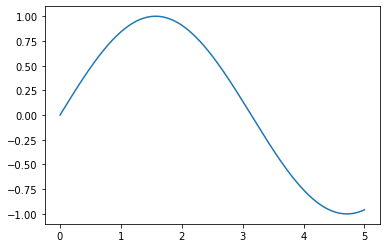

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

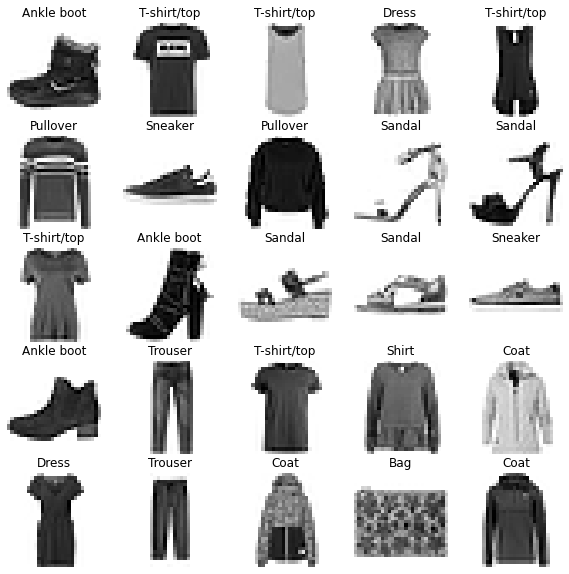

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Train on 60000 samples
Epoch 1/5


   32/60000 [..............................] - ETA: 11:25 - loss: 2.4660 - accuracy: 0.1250

  736/60000 [..............................] - ETA: 33s - loss: 1.5123 - accuracy: 0.5109  

 1504/60000 [..............................] - ETA: 18s - loss: 1.1959 - accuracy: 0.6057

 2304/60000 [>.............................] - ETA: 12s - loss: 1.0602 - accuracy: 0.6471

 3072/60000 [>.............................] - ETA: 10s - loss: 0.9727 - accuracy: 0.6771

 3872/60000 [>.............................] - ETA: 9s - loss: 0.9145 - accuracy: 0.6963 

 4672/60000 [=>............................] - ETA: 7s - loss: 0.8767 - accuracy: 0.7074

 5472/60000 [=>............................] - ETA: 7s - loss: 0.8397 - accuracy: 0.7186

 6240/60000 [==>...........................] - ETA: 6s - loss: 0.8189 - accuracy: 0.7223

 7008/60000 [==>...........................] - ETA: 6s - loss: 0.7937 - accuracy: 0.7277

 7872/60000 [==>...........................] - ETA: 5s - loss: 0.7658 - accuracy: 0.7358

 8672/60000 [===>..........................] - ETA: 5s - loss: 0.7435 - accuracy: 0.7435

 9472/60000 [===>..........................] - ETA: 5s - loss: 0.7257 - accuracy: 0.7511

10208/60000 [====>.........................] - ETA: 5s - loss: 0.7133 - accuracy: 0.7554

11136/60000 [====>.........................] - ETA: 4s - loss: 0.6981 - accuracy: 0.7609

12000/60000 [=====>........................] - ETA: 4s - loss: 0.6906 - accuracy: 0.7641

12800/60000 [=====>........................] - ETA: 4s - loss: 0.6794 - accuracy: 0.7671

13632/60000 [=====>........................] - ETA: 4s - loss: 0.6653 - accuracy: 0.7719

14432/60000 [======>.......................] - ETA: 4s - loss: 0.6580 - accuracy: 0.7739

15264/60000 [======>.......................] - ETA: 3s - loss: 0.6486 - accuracy: 0.7771

16128/60000 [=======>......................] - ETA: 3s - loss: 0.6405 - accuracy: 0.7797

16928/60000 [=======>......................] - ETA: 3s - loss: 0.6338 - accuracy: 0.7821

17728/60000 [=======>......................] - ETA: 3s - loss: 0.6282 - accuracy: 0.7834

18464/60000 [========>.....................] - ETA: 3s - loss: 0.6230 - accuracy: 0.7849

19264/60000 [========>.....................] - ETA: 3s - loss: 0.6194 - accuracy: 0.7863

20096/60000 [=========>....................] - ETA: 3s - loss: 0.6153 - accuracy: 0.7879

20864/60000 [=========>....................] - ETA: 3s - loss: 0.6104 - accuracy: 0.7896

21696/60000 [=========>....................] - ETA: 3s - loss: 0.6027 - accuracy: 0.7926

22464/60000 [==========>...................] - ETA: 3s - loss: 0.5989 - accuracy: 0.7941

23264/60000 [==========>...................] - ETA: 2s - loss: 0.5940 - accuracy: 0.7961

24000/60000 [===========>..................] - ETA: 2s - loss: 0.5908 - accuracy: 0.7967

24896/60000 [===========>..................] - ETA: 2s - loss: 0.5892 - accuracy: 0.7972

25728/60000 [===========>..................] - ETA: 2s - loss: 0.5857 - accuracy: 0.7983

26624/60000 [============>.................] - ETA: 2s - loss: 0.5808 - accuracy: 0.8003

27456/60000 [============>.................] - ETA: 2s - loss: 0.5767 - accuracy: 0.8015

28224/60000 [=============>................] - ETA: 2s - loss: 0.5731 - accuracy: 0.8030

29120/60000 [=============>................] - ETA: 2s - loss: 0.5711 - accuracy: 0.8036

29888/60000 [=============>................] - ETA: 2s - loss: 0.5679 - accuracy: 0.8046

30688/60000 [==============>...............] - ETA: 2s - loss: 0.5654 - accuracy: 0.8050

31360/60000 [==============>...............] - ETA: 2s - loss: 0.5632 - accuracy: 0.8057

32000/60000 [===============>..............] - ETA: 2s - loss: 0.5610 - accuracy: 0.8065

32672/60000 [===============>..............] - ETA: 2s - loss: 0.5585 - accuracy: 0.8073

33344/60000 [===============>..............] - ETA: 2s - loss: 0.5560 - accuracy: 0.8081

33952/60000 [===============>..............] - ETA: 1s - loss: 0.5536 - accuracy: 0.8091

34560/60000 [================>.............] - ETA: 1s - loss: 0.5510 - accuracy: 0.8094

35136/60000 [================>.............] - ETA: 1s - loss: 0.5491 - accuracy: 0.8099

36000/60000 [=================>............] - ETA: 1s - loss: 0.5472 - accuracy: 0.8102

36864/60000 [=================>............] - ETA: 1s - loss: 0.5447 - accuracy: 0.8111

37664/60000 [=================>............] - ETA: 1s - loss: 0.5425 - accuracy: 0.8119

38464/60000 [==================>...........] - ETA: 1s - loss: 0.5394 - accuracy: 0.8128

39200/60000 [==================>...........] - ETA: 1s - loss: 0.5367 - accuracy: 0.8138

39968/60000 [==================>...........] - ETA: 1s - loss: 0.5348 - accuracy: 0.8144

40672/60000 [===================>..........] - ETA: 1s - loss: 0.5336 - accuracy: 0.8148

41504/60000 [===================>..........] - ETA: 1s - loss: 0.5314 - accuracy: 0.8159

42144/60000 [====================>.........] - ETA: 1s - loss: 0.5301 - accuracy: 0.8165

42848/60000 [====================>.........] - ETA: 1s - loss: 0.5286 - accuracy: 0.8167

43648/60000 [====================>.........] - ETA: 1s - loss: 0.5266 - accuracy: 0.8172

44384/60000 [=====================>........] - ETA: 1s - loss: 0.5247 - accuracy: 0.8179

45088/60000 [=====================>........] - ETA: 1s - loss: 0.5230 - accuracy: 0.8185

45824/60000 [=====================>........] - ETA: 1s - loss: 0.5212 - accuracy: 0.8191

46656/60000 [======================>.......] - ETA: 0s - loss: 0.5203 - accuracy: 0.8193

47424/60000 [======================>.......] - ETA: 0s - loss: 0.5189 - accuracy: 0.8196

48256/60000 [=======================>......] - ETA: 0s - loss: 0.5166 - accuracy: 0.8202

49056/60000 [=======================>......] - ETA: 0s - loss: 0.5157 - accuracy: 0.8205

49888/60000 [=======================>......] - ETA: 0s - loss: 0.5147 - accuracy: 0.8209

50624/60000 [========================>.....] - ETA: 0s - loss: 0.5131 - accuracy: 0.8214

51424/60000 [========================>.....] - ETA: 0s - loss: 0.5124 - accuracy: 0.8218

52224/60000 [=========================>....] - ETA: 0s - loss: 0.5103 - accuracy: 0.8224

53088/60000 [=========================>....] - ETA: 0s - loss: 0.5082 - accuracy: 0.8231

53920/60000 [=========================>....] - ETA: 0s - loss: 0.5066 - accuracy: 0.8236

54720/60000 [==========================>...] - ETA: 0s - loss: 0.5048 - accuracy: 0.8242

55584/60000 [==========================>...] - ETA: 0s - loss: 0.5034 - accuracy: 0.8247

56416/60000 [===========================>..] - ETA: 0s - loss: 0.5025 - accuracy: 0.8251

57248/60000 [===========================>..] - ETA: 0s - loss: 0.5009 - accuracy: 0.8257

58080/60000 [============================>.] - ETA: 0s - loss: 0.4991 - accuracy: 0.8261

58912/60000 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.8268

59712/60000 [============================>.] - ETA: 0s - loss: 0.4962 - accuracy: 0.8269

60000/60000 [==============================] - 4s 71us/sample - loss: 0.4954 - accuracy: 0.8272


Epoch 2/5
   32/60000 [..............................] - ETA: 5s - loss: 0.2882 - accuracy: 0.8750

  736/60000 [..............................] - ETA: 4s - loss: 0.3576 - accuracy: 0.8696

 1568/60000 [..............................] - ETA: 3s - loss: 0.3863 - accuracy: 0.8635

 2432/60000 [>.............................] - ETA: 3s - loss: 0.3893 - accuracy: 0.8586

 3072/60000 [>.............................] - ETA: 3s - loss: 0.3943 - accuracy: 0.8620

 4032/60000 [=>............................] - ETA: 3s - loss: 0.3982 - accuracy: 0.8606

 4896/60000 [=>............................] - ETA: 3s - loss: 0.4037 - accuracy: 0.8562

 5728/60000 [=>............................] - ETA: 3s - loss: 0.4010 - accuracy: 0.8572

 6528/60000 [==>...........................] - ETA: 3s - loss: 0.3987 - accuracy: 0.8578

 7264/60000 [==>...........................] - ETA: 3s - loss: 0.3980 - accuracy: 0.8581

 8032/60000 [===>..........................] - ETA: 3s - loss: 0.3943 - accuracy: 0.8586

 8800/60000 [===>..........................] - ETA: 3s - loss: 0.3954 - accuracy: 0.8578

 9664/60000 [===>..........................] - ETA: 3s - loss: 0.3976 - accuracy: 0.8565

10432/60000 [====>.........................] - ETA: 3s - loss: 0.3998 - accuracy: 0.8553

11232/60000 [====>.........................] - ETA: 3s - loss: 0.4007 - accuracy: 0.8554

11904/60000 [====>.........................] - ETA: 3s - loss: 0.3989 - accuracy: 0.8555

12736/60000 [=====>........................] - ETA: 3s - loss: 0.3985 - accuracy: 0.8563

13536/60000 [=====>........................] - ETA: 2s - loss: 0.3981 - accuracy: 0.8570

14272/60000 [======>.......................] - ETA: 2s - loss: 0.3979 - accuracy: 0.8573

15008/60000 [======>.......................] - ETA: 2s - loss: 0.3964 - accuracy: 0.8579

15776/60000 [======>.......................] - ETA: 2s - loss: 0.3950 - accuracy: 0.8582

16512/60000 [=======>......................] - ETA: 2s - loss: 0.3948 - accuracy: 0.8581

17344/60000 [=======>......................] - ETA: 2s - loss: 0.3945 - accuracy: 0.8582

18080/60000 [========>.....................] - ETA: 2s - loss: 0.3921 - accuracy: 0.8593

18848/60000 [========>.....................] - ETA: 2s - loss: 0.3903 - accuracy: 0.8601

19712/60000 [========>.....................] - ETA: 2s - loss: 0.3908 - accuracy: 0.8594

20544/60000 [=========>....................] - ETA: 2s - loss: 0.3908 - accuracy: 0.8593

21344/60000 [=========>....................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8595

22144/60000 [==========>...................] - ETA: 2s - loss: 0.3903 - accuracy: 0.8593

22976/60000 [==========>...................] - ETA: 2s - loss: 0.3898 - accuracy: 0.8597

23776/60000 [==========>...................] - ETA: 2s - loss: 0.3906 - accuracy: 0.8591

24512/60000 [===========>..................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8589

25312/60000 [===========>..................] - ETA: 2s - loss: 0.3896 - accuracy: 0.8590

26080/60000 [============>.................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8589

26848/60000 [============>.................] - ETA: 2s - loss: 0.3888 - accuracy: 0.8594

27616/60000 [============>.................] - ETA: 2s - loss: 0.3885 - accuracy: 0.8596

28544/60000 [=============>................] - ETA: 2s - loss: 0.3867 - accuracy: 0.8603

29248/60000 [=============>................] - ETA: 1s - loss: 0.3853 - accuracy: 0.8608

30112/60000 [==============>...............] - ETA: 1s - loss: 0.3841 - accuracy: 0.8610

30976/60000 [==============>...............] - ETA: 1s - loss: 0.3834 - accuracy: 0.8612

31840/60000 [==============>...............] - ETA: 1s - loss: 0.3821 - accuracy: 0.8618

32736/60000 [===============>..............] - ETA: 1s - loss: 0.3816 - accuracy: 0.8620

33632/60000 [===============>..............] - ETA: 1s - loss: 0.3823 - accuracy: 0.8614

34272/60000 [================>.............] - ETA: 1s - loss: 0.3817 - accuracy: 0.8617

35168/60000 [================>.............] - ETA: 1s - loss: 0.3831 - accuracy: 0.8612

35968/60000 [================>.............] - ETA: 1s - loss: 0.3829 - accuracy: 0.8615

36832/60000 [=================>............] - ETA: 1s - loss: 0.3819 - accuracy: 0.8621

37696/60000 [=================>............] - ETA: 1s - loss: 0.3806 - accuracy: 0.8626

38496/60000 [==================>...........] - ETA: 1s - loss: 0.3801 - accuracy: 0.8627

39360/60000 [==================>...........] - ETA: 1s - loss: 0.3795 - accuracy: 0.8629

40096/60000 [===================>..........] - ETA: 1s - loss: 0.3794 - accuracy: 0.8630

40896/60000 [===================>..........] - ETA: 1s - loss: 0.3794 - accuracy: 0.8630

41728/60000 [===================>..........] - ETA: 1s - loss: 0.3803 - accuracy: 0.8627

42688/60000 [====================>.........] - ETA: 1s - loss: 0.3807 - accuracy: 0.8623

43648/60000 [====================>.........] - ETA: 1s - loss: 0.3809 - accuracy: 0.8623

44448/60000 [=====================>........] - ETA: 0s - loss: 0.3804 - accuracy: 0.8624

45280/60000 [=====================>........] - ETA: 0s - loss: 0.3800 - accuracy: 0.8622

46080/60000 [======================>.......] - ETA: 0s - loss: 0.3788 - accuracy: 0.8628

46880/60000 [======================>.......] - ETA: 0s - loss: 0.3783 - accuracy: 0.8629

47808/60000 [======================>.......] - ETA: 0s - loss: 0.3776 - accuracy: 0.8631

48704/60000 [=======================>......] - ETA: 0s - loss: 0.3769 - accuracy: 0.8633

49568/60000 [=======================>......] - ETA: 0s - loss: 0.3768 - accuracy: 0.8634

50272/60000 [========================>.....] - ETA: 0s - loss: 0.3760 - accuracy: 0.8638

50976/60000 [========================>.....] - ETA: 0s - loss: 0.3751 - accuracy: 0.8641

51744/60000 [========================>.....] - ETA: 0s - loss: 0.3745 - accuracy: 0.8644

52544/60000 [=========================>....] - ETA: 0s - loss: 0.3744 - accuracy: 0.8645

53312/60000 [=========================>....] - ETA: 0s - loss: 0.3740 - accuracy: 0.8646

54080/60000 [==========================>...] - ETA: 0s - loss: 0.3735 - accuracy: 0.8646

54688/60000 [==========================>...] - ETA: 0s - loss: 0.3727 - accuracy: 0.8649

55360/60000 [==========================>...] - ETA: 0s - loss: 0.3731 - accuracy: 0.8649

56032/60000 [===========================>..] - ETA: 0s - loss: 0.3731 - accuracy: 0.8651

56736/60000 [===========================>..] - ETA: 0s - loss: 0.3728 - accuracy: 0.8651

57472/60000 [===========================>..] - ETA: 0s - loss: 0.3724 - accuracy: 0.8653

58240/60000 [============================>.] - ETA: 0s - loss: 0.3722 - accuracy: 0.8652

59008/60000 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8651

59744/60000 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8653

60000/60000 [==============================] - 4s 64us/sample - loss: 0.3718 - accuracy: 0.8653


Epoch 3/5
   32/60000 [..............................] - ETA: 7s - loss: 0.3796 - accuracy: 0.8438

  832/60000 [..............................] - ETA: 3s - loss: 0.3541 - accuracy: 0.8762

 1568/60000 [..............................] - ETA: 3s - loss: 0.3304 - accuracy: 0.8827

 2368/60000 [>.............................] - ETA: 3s - loss: 0.3389 - accuracy: 0.8780

 3040/60000 [>.............................] - ETA: 3s - loss: 0.3407 - accuracy: 0.8776

 3488/60000 [>.............................] - ETA: 4s - loss: 0.3494 - accuracy: 0.8776

 3904/60000 [>.............................] - ETA: 4s - loss: 0.3473 - accuracy: 0.8781

 4288/60000 [=>............................] - ETA: 4s - loss: 0.3458 - accuracy: 0.8778

 4768/60000 [=>............................] - ETA: 4s - loss: 0.3443 - accuracy: 0.8786

 5088/60000 [=>............................] - ETA: 5s - loss: 0.3474 - accuracy: 0.8778

 5696/60000 [=>............................] - ETA: 4s - loss: 0.3438 - accuracy: 0.8787

 5952/60000 [=>............................] - ETA: 5s - loss: 0.3427 - accuracy: 0.8794

 6368/60000 [==>...........................] - ETA: 5s - loss: 0.3420 - accuracy: 0.8788

 6784/60000 [==>...........................] - ETA: 5s - loss: 0.3408 - accuracy: 0.8796

 7392/60000 [==>...........................] - ETA: 5s - loss: 0.3410 - accuracy: 0.8782

 8032/60000 [===>..........................] - ETA: 5s - loss: 0.3429 - accuracy: 0.8784

 8800/60000 [===>..........................] - ETA: 4s - loss: 0.3449 - accuracy: 0.8777

 9504/60000 [===>..........................] - ETA: 4s - loss: 0.3407 - accuracy: 0.8787

10272/60000 [====>.........................] - ETA: 4s - loss: 0.3375 - accuracy: 0.8800

11040/60000 [====>.........................] - ETA: 4s - loss: 0.3366 - accuracy: 0.8803

11872/60000 [====>.........................] - ETA: 4s - loss: 0.3370 - accuracy: 0.8802

12544/60000 [=====>........................] - ETA: 4s - loss: 0.3380 - accuracy: 0.8795

13344/60000 [=====>........................] - ETA: 3s - loss: 0.3342 - accuracy: 0.8811

14144/60000 [======>.......................] - ETA: 3s - loss: 0.3339 - accuracy: 0.8809

14848/60000 [======>.......................] - ETA: 3s - loss: 0.3344 - accuracy: 0.8803

15488/60000 [======>.......................] - ETA: 3s - loss: 0.3337 - accuracy: 0.8800

16256/60000 [=======>......................] - ETA: 3s - loss: 0.3345 - accuracy: 0.8792

16864/60000 [=======>......................] - ETA: 3s - loss: 0.3343 - accuracy: 0.8796

17600/60000 [=======>......................] - ETA: 3s - loss: 0.3330 - accuracy: 0.8798

18496/60000 [========>.....................] - ETA: 3s - loss: 0.3338 - accuracy: 0.8799

19296/60000 [========>.....................] - ETA: 3s - loss: 0.3347 - accuracy: 0.8790

20000/60000 [=========>....................] - ETA: 3s - loss: 0.3378 - accuracy: 0.8777

20736/60000 [=========>....................] - ETA: 3s - loss: 0.3379 - accuracy: 0.8775

21472/60000 [=========>....................] - ETA: 3s - loss: 0.3364 - accuracy: 0.8784

22208/60000 [==========>...................] - ETA: 2s - loss: 0.3356 - accuracy: 0.8783

22912/60000 [==========>...................] - ETA: 2s - loss: 0.3350 - accuracy: 0.8786

23744/60000 [==========>...................] - ETA: 2s - loss: 0.3355 - accuracy: 0.8784

24608/60000 [===========>..................] - ETA: 2s - loss: 0.3357 - accuracy: 0.8780

25312/60000 [===========>..................] - ETA: 2s - loss: 0.3350 - accuracy: 0.8784

25984/60000 [===========>..................] - ETA: 2s - loss: 0.3343 - accuracy: 0.8788

26656/60000 [============>.................] - ETA: 2s - loss: 0.3342 - accuracy: 0.8788

27392/60000 [============>.................] - ETA: 2s - loss: 0.3341 - accuracy: 0.8790

28160/60000 [=============>................] - ETA: 2s - loss: 0.3345 - accuracy: 0.8790

28992/60000 [=============>................] - ETA: 2s - loss: 0.3342 - accuracy: 0.8794

29760/60000 [=============>................] - ETA: 2s - loss: 0.3349 - accuracy: 0.8790

30528/60000 [==============>...............] - ETA: 2s - loss: 0.3346 - accuracy: 0.8791

31360/60000 [==============>...............] - ETA: 2s - loss: 0.3338 - accuracy: 0.8793

32128/60000 [===============>..............] - ETA: 2s - loss: 0.3339 - accuracy: 0.8792

32960/60000 [===============>..............] - ETA: 2s - loss: 0.3328 - accuracy: 0.8800

33600/60000 [===============>..............] - ETA: 1s - loss: 0.3324 - accuracy: 0.8801

34464/60000 [================>.............] - ETA: 1s - loss: 0.3323 - accuracy: 0.8800

35296/60000 [================>.............] - ETA: 1s - loss: 0.3323 - accuracy: 0.8800

36064/60000 [=================>............] - ETA: 1s - loss: 0.3318 - accuracy: 0.8804

36800/60000 [=================>............] - ETA: 1s - loss: 0.3308 - accuracy: 0.8808

37728/60000 [=================>............] - ETA: 1s - loss: 0.3305 - accuracy: 0.8811

38560/60000 [==================>...........] - ETA: 1s - loss: 0.3306 - accuracy: 0.8807

39392/60000 [==================>...........] - ETA: 1s - loss: 0.3318 - accuracy: 0.8803

40192/60000 [===================>..........] - ETA: 1s - loss: 0.3320 - accuracy: 0.8802

41056/60000 [===================>..........] - ETA: 1s - loss: 0.3321 - accuracy: 0.8801

41984/60000 [===================>..........] - ETA: 1s - loss: 0.3329 - accuracy: 0.8798

42816/60000 [====================>.........] - ETA: 1s - loss: 0.3325 - accuracy: 0.8801

43680/60000 [====================>.........] - ETA: 1s - loss: 0.3321 - accuracy: 0.8802

44512/60000 [=====================>........] - ETA: 1s - loss: 0.3319 - accuracy: 0.8803

45248/60000 [=====================>........] - ETA: 1s - loss: 0.3322 - accuracy: 0.8802

46048/60000 [======================>.......] - ETA: 0s - loss: 0.3329 - accuracy: 0.8799

46912/60000 [======================>.......] - ETA: 0s - loss: 0.3331 - accuracy: 0.8800

47616/60000 [======================>.......] - ETA: 0s - loss: 0.3333 - accuracy: 0.8799

48512/60000 [=======================>......] - ETA: 0s - loss: 0.3331 - accuracy: 0.8801

49344/60000 [=======================>......] - ETA: 0s - loss: 0.3338 - accuracy: 0.8797

50208/60000 [========================>.....] - ETA: 0s - loss: 0.3346 - accuracy: 0.8795

50944/60000 [========================>.....] - ETA: 0s - loss: 0.3345 - accuracy: 0.8793

51744/60000 [========================>.....] - ETA: 0s - loss: 0.3339 - accuracy: 0.8795

52576/60000 [=========================>....] - ETA: 0s - loss: 0.3339 - accuracy: 0.8795

53376/60000 [=========================>....] - ETA: 0s - loss: 0.3345 - accuracy: 0.8792

54112/60000 [==========================>...] - ETA: 0s - loss: 0.3341 - accuracy: 0.8793

54816/60000 [==========================>...] - ETA: 0s - loss: 0.3349 - accuracy: 0.8790

55488/60000 [==========================>...] - ETA: 0s - loss: 0.3344 - accuracy: 0.8790

56160/60000 [===========================>..] - ETA: 0s - loss: 0.3346 - accuracy: 0.8790

56768/60000 [===========================>..] - ETA: 0s - loss: 0.3344 - accuracy: 0.8792

57408/60000 [===========================>..] - ETA: 0s - loss: 0.3340 - accuracy: 0.8792

58048/60000 [============================>.] - ETA: 0s - loss: 0.3338 - accuracy: 0.8793

58752/60000 [============================>.] - ETA: 0s - loss: 0.3330 - accuracy: 0.8797

59456/60000 [============================>.] - ETA: 0s - loss: 0.3335 - accuracy: 0.8794

60000/60000 [==============================] - 4s 71us/sample - loss: 0.3336 - accuracy: 0.8794


Epoch 4/5
   32/60000 [..............................] - ETA: 7s - loss: 0.3291 - accuracy: 0.8438

  704/60000 [..............................] - ETA: 4s - loss: 0.2704 - accuracy: 0.9020

 1376/60000 [..............................] - ETA: 4s - loss: 0.2898 - accuracy: 0.8939

 2048/60000 [>.............................] - ETA: 4s - loss: 0.2963 - accuracy: 0.8936

 2816/60000 [>.............................] - ETA: 4s - loss: 0.3036 - accuracy: 0.8920

 3424/60000 [>.............................] - ETA: 4s - loss: 0.3053 - accuracy: 0.8893

 4064/60000 [=>............................] - ETA: 4s - loss: 0.3120 - accuracy: 0.8858

 4736/60000 [=>............................] - ETA: 4s - loss: 0.3173 - accuracy: 0.8843

 5440/60000 [=>............................] - ETA: 4s - loss: 0.3205 - accuracy: 0.8846

 6080/60000 [==>...........................] - ETA: 4s - loss: 0.3172 - accuracy: 0.8852

 6784/60000 [==>...........................] - ETA: 4s - loss: 0.3164 - accuracy: 0.8861

 7392/60000 [==>...........................] - ETA: 4s - loss: 0.3148 - accuracy: 0.8868

 8032/60000 [===>..........................] - ETA: 3s - loss: 0.3137 - accuracy: 0.8876

 8736/60000 [===>..........................] - ETA: 3s - loss: 0.3117 - accuracy: 0.8886

 9344/60000 [===>..........................] - ETA: 3s - loss: 0.3113 - accuracy: 0.8891

10080/60000 [====>.........................] - ETA: 3s - loss: 0.3107 - accuracy: 0.8885

10720/60000 [====>.........................] - ETA: 3s - loss: 0.3078 - accuracy: 0.8897

11360/60000 [====>.........................] - ETA: 3s - loss: 0.3061 - accuracy: 0.8906

12000/60000 [=====>........................] - ETA: 3s - loss: 0.3065 - accuracy: 0.8892

12704/60000 [=====>........................] - ETA: 3s - loss: 0.3058 - accuracy: 0.8898

13376/60000 [=====>........................] - ETA: 3s - loss: 0.3047 - accuracy: 0.8900

14080/60000 [======>.......................] - ETA: 3s - loss: 0.3077 - accuracy: 0.8893

14720/60000 [======>.......................] - ETA: 3s - loss: 0.3066 - accuracy: 0.8899

15392/60000 [======>.......................] - ETA: 3s - loss: 0.3054 - accuracy: 0.8906

16160/60000 [=======>......................] - ETA: 3s - loss: 0.3058 - accuracy: 0.8907

16832/60000 [=======>......................] - ETA: 3s - loss: 0.3060 - accuracy: 0.8906

17440/60000 [=======>......................] - ETA: 3s - loss: 0.3053 - accuracy: 0.8905

18080/60000 [========>.....................] - ETA: 3s - loss: 0.3069 - accuracy: 0.8899

18752/60000 [========>.....................] - ETA: 3s - loss: 0.3083 - accuracy: 0.8891

19424/60000 [========>.....................] - ETA: 3s - loss: 0.3075 - accuracy: 0.8891

20160/60000 [=========>....................] - ETA: 3s - loss: 0.3057 - accuracy: 0.8899

20832/60000 [=========>....................] - ETA: 2s - loss: 0.3062 - accuracy: 0.8896

21440/60000 [=========>....................] - ETA: 2s - loss: 0.3057 - accuracy: 0.8898

22048/60000 [==========>...................] - ETA: 2s - loss: 0.3048 - accuracy: 0.8905

22688/60000 [==========>...................] - ETA: 2s - loss: 0.3040 - accuracy: 0.8906

23360/60000 [==========>...................] - ETA: 2s - loss: 0.3043 - accuracy: 0.8905

24000/60000 [===========>..................] - ETA: 2s - loss: 0.3049 - accuracy: 0.8900

24608/60000 [===========>..................] - ETA: 2s - loss: 0.3052 - accuracy: 0.8898

25312/60000 [===========>..................] - ETA: 2s - loss: 0.3057 - accuracy: 0.8892

25984/60000 [===========>..................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8895

26624/60000 [============>.................] - ETA: 2s - loss: 0.3053 - accuracy: 0.8893

27232/60000 [============>.................] - ETA: 2s - loss: 0.3051 - accuracy: 0.8894

27904/60000 [============>.................] - ETA: 2s - loss: 0.3065 - accuracy: 0.8886

28544/60000 [=============>................] - ETA: 2s - loss: 0.3050 - accuracy: 0.8896

29248/60000 [=============>................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8893

29920/60000 [=============>................] - ETA: 2s - loss: 0.3057 - accuracy: 0.8892

30624/60000 [==============>...............] - ETA: 2s - loss: 0.3052 - accuracy: 0.8894

31264/60000 [==============>...............] - ETA: 2s - loss: 0.3057 - accuracy: 0.8892

31904/60000 [==============>...............] - ETA: 2s - loss: 0.3048 - accuracy: 0.8894

32544/60000 [===============>..............] - ETA: 2s - loss: 0.3058 - accuracy: 0.8890

33216/60000 [===============>..............] - ETA: 2s - loss: 0.3056 - accuracy: 0.8889

33856/60000 [===============>..............] - ETA: 2s - loss: 0.3072 - accuracy: 0.8886

34496/60000 [================>.............] - ETA: 1s - loss: 0.3072 - accuracy: 0.8885

35168/60000 [================>.............] - ETA: 1s - loss: 0.3073 - accuracy: 0.8883

35840/60000 [================>.............] - ETA: 1s - loss: 0.3062 - accuracy: 0.8886

36480/60000 [=================>............] - ETA: 1s - loss: 0.3058 - accuracy: 0.8887

37120/60000 [=================>............] - ETA: 1s - loss: 0.3064 - accuracy: 0.8883

37728/60000 [=================>............] - ETA: 1s - loss: 0.3059 - accuracy: 0.8884

38400/60000 [==================>...........] - ETA: 1s - loss: 0.3056 - accuracy: 0.8885

39040/60000 [==================>...........] - ETA: 1s - loss: 0.3066 - accuracy: 0.8882

39712/60000 [==================>...........] - ETA: 1s - loss: 0.3066 - accuracy: 0.8884

40384/60000 [===================>..........] - ETA: 1s - loss: 0.3067 - accuracy: 0.8883

41152/60000 [===================>..........] - ETA: 1s - loss: 0.3063 - accuracy: 0.8884

41856/60000 [===================>..........] - ETA: 1s - loss: 0.3065 - accuracy: 0.8884

42560/60000 [====================>.........] - ETA: 1s - loss: 0.3076 - accuracy: 0.8880

43328/60000 [====================>.........] - ETA: 1s - loss: 0.3080 - accuracy: 0.8879

43968/60000 [====================>.........] - ETA: 1s - loss: 0.3079 - accuracy: 0.8879

44640/60000 [=====================>........] - ETA: 1s - loss: 0.3090 - accuracy: 0.8875

45344/60000 [=====================>........] - ETA: 1s - loss: 0.3087 - accuracy: 0.8877

46048/60000 [======================>.......] - ETA: 1s - loss: 0.3100 - accuracy: 0.8872

46688/60000 [======================>.......] - ETA: 1s - loss: 0.3096 - accuracy: 0.8875

47328/60000 [======================>.......] - ETA: 0s - loss: 0.3105 - accuracy: 0.8871

47968/60000 [======================>.......] - ETA: 0s - loss: 0.3102 - accuracy: 0.8872

48672/60000 [=======================>......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8874

49376/60000 [=======================>......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8874

50016/60000 [========================>.....] - ETA: 0s - loss: 0.3101 - accuracy: 0.8872

50624/60000 [========================>.....] - ETA: 0s - loss: 0.3106 - accuracy: 0.8871

51328/60000 [========================>.....] - ETA: 0s - loss: 0.3097 - accuracy: 0.8875

52064/60000 [=========================>....] - ETA: 0s - loss: 0.3102 - accuracy: 0.8874

52704/60000 [=========================>....] - ETA: 0s - loss: 0.3102 - accuracy: 0.8873

53408/60000 [=========================>....] - ETA: 0s - loss: 0.3102 - accuracy: 0.8873

54080/60000 [==========================>...] - ETA: 0s - loss: 0.3100 - accuracy: 0.8874

54752/60000 [==========================>...] - ETA: 0s - loss: 0.3098 - accuracy: 0.8873

55488/60000 [==========================>...] - ETA: 0s - loss: 0.3098 - accuracy: 0.8874

56160/60000 [===========================>..] - ETA: 0s - loss: 0.3095 - accuracy: 0.8874

56864/60000 [===========================>..] - ETA: 0s - loss: 0.3093 - accuracy: 0.8874

57536/60000 [===========================>..] - ETA: 0s - loss: 0.3095 - accuracy: 0.8873

58144/60000 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8873

58816/60000 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8875

59488/60000 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8873

60000/60000 [==============================] - 5s 77us/sample - loss: 0.3091 - accuracy: 0.8874


Epoch 5/5


   32/60000 [..............................] - ETA: 7s - loss: 0.4132 - accuracy: 0.8125

  672/60000 [..............................] - ETA: 4s - loss: 0.2729 - accuracy: 0.9003

 1376/60000 [..............................] - ETA: 4s - loss: 0.2547 - accuracy: 0.9055

 2048/60000 [>.............................] - ETA: 4s - loss: 0.2604 - accuracy: 0.9033

 2720/60000 [>.............................] - ETA: 4s - loss: 0.2604 - accuracy: 0.9033

 3328/60000 [>.............................] - ETA: 4s - loss: 0.2631 - accuracy: 0.9035

 4064/60000 [=>............................] - ETA: 4s - loss: 0.2593 - accuracy: 0.9031

 4768/60000 [=>............................] - ETA: 4s - loss: 0.2627 - accuracy: 0.9031

 5408/60000 [=>............................] - ETA: 4s - loss: 0.2630 - accuracy: 0.9037

 6016/60000 [==>...........................] - ETA: 4s - loss: 0.2640 - accuracy: 0.9018

 6656/60000 [==>...........................] - ETA: 4s - loss: 0.2638 - accuracy: 0.9007

 7392/60000 [==>...........................] - ETA: 4s - loss: 0.2662 - accuracy: 0.9006

 8064/60000 [===>..........................] - ETA: 3s - loss: 0.2708 - accuracy: 0.8987

 8704/60000 [===>..........................] - ETA: 3s - loss: 0.2725 - accuracy: 0.8987

 9408/60000 [===>..........................] - ETA: 3s - loss: 0.2748 - accuracy: 0.8981

10080/60000 [====>.........................] - ETA: 3s - loss: 0.2785 - accuracy: 0.8966

10752/60000 [====>.........................] - ETA: 3s - loss: 0.2791 - accuracy: 0.8966

11424/60000 [====>.........................] - ETA: 3s - loss: 0.2796 - accuracy: 0.8965

12064/60000 [=====>........................] - ETA: 3s - loss: 0.2788 - accuracy: 0.8968

12768/60000 [=====>........................] - ETA: 3s - loss: 0.2811 - accuracy: 0.8963

13472/60000 [=====>........................] - ETA: 3s - loss: 0.2809 - accuracy: 0.8967

14112/60000 [======>.......................] - ETA: 3s - loss: 0.2818 - accuracy: 0.8963

14784/60000 [======>.......................] - ETA: 3s - loss: 0.2819 - accuracy: 0.8963

15424/60000 [======>.......................] - ETA: 3s - loss: 0.2811 - accuracy: 0.8967

16096/60000 [=======>......................] - ETA: 3s - loss: 0.2821 - accuracy: 0.8961

16768/60000 [=======>......................] - ETA: 3s - loss: 0.2819 - accuracy: 0.8962

17408/60000 [=======>......................] - ETA: 3s - loss: 0.2825 - accuracy: 0.8957

18048/60000 [========>.....................] - ETA: 3s - loss: 0.2834 - accuracy: 0.8956

18624/60000 [========>.....................] - ETA: 3s - loss: 0.2847 - accuracy: 0.8951

19264/60000 [========>.....................] - ETA: 3s - loss: 0.2861 - accuracy: 0.8948

19936/60000 [========>.....................] - ETA: 3s - loss: 0.2868 - accuracy: 0.8946

20544/60000 [=========>....................] - ETA: 3s - loss: 0.2876 - accuracy: 0.8941

21216/60000 [=========>....................] - ETA: 3s - loss: 0.2873 - accuracy: 0.8944

21856/60000 [=========>....................] - ETA: 2s - loss: 0.2858 - accuracy: 0.8947

22432/60000 [==========>...................] - ETA: 2s - loss: 0.2858 - accuracy: 0.8947

23040/60000 [==========>...................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8943

23712/60000 [==========>...................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8939

24448/60000 [===========>..................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8940

25120/60000 [===========>..................] - ETA: 2s - loss: 0.2877 - accuracy: 0.8939

25824/60000 [===========>..................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8934

26432/60000 [============>.................] - ETA: 2s - loss: 0.2887 - accuracy: 0.8935

27072/60000 [============>.................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8932

27712/60000 [============>.................] - ETA: 2s - loss: 0.2892 - accuracy: 0.8930

28384/60000 [=============>................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8935

29088/60000 [=============>................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8937

29760/60000 [=============>................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8939

30368/60000 [==============>...............] - ETA: 2s - loss: 0.2878 - accuracy: 0.8939

31040/60000 [==============>...............] - ETA: 2s - loss: 0.2876 - accuracy: 0.8939

31648/60000 [==============>...............] - ETA: 2s - loss: 0.2874 - accuracy: 0.8939

32320/60000 [===============>..............] - ETA: 2s - loss: 0.2874 - accuracy: 0.8936

33024/60000 [===============>..............] - ETA: 2s - loss: 0.2869 - accuracy: 0.8939

33600/60000 [===============>..............] - ETA: 2s - loss: 0.2864 - accuracy: 0.8942

34208/60000 [================>.............] - ETA: 2s - loss: 0.2867 - accuracy: 0.8939

34848/60000 [================>.............] - ETA: 1s - loss: 0.2863 - accuracy: 0.8940

35520/60000 [================>.............] - ETA: 1s - loss: 0.2859 - accuracy: 0.8942

36192/60000 [=================>............] - ETA: 1s - loss: 0.2864 - accuracy: 0.8941

36864/60000 [=================>............] - ETA: 1s - loss: 0.2864 - accuracy: 0.8942

37632/60000 [=================>............] - ETA: 1s - loss: 0.2874 - accuracy: 0.8939

38272/60000 [==================>...........] - ETA: 1s - loss: 0.2879 - accuracy: 0.8936

39008/60000 [==================>...........] - ETA: 1s - loss: 0.2876 - accuracy: 0.8937

39712/60000 [==================>...........] - ETA: 1s - loss: 0.2872 - accuracy: 0.8938

40416/60000 [===================>..........] - ETA: 1s - loss: 0.2875 - accuracy: 0.8936

41088/60000 [===================>..........] - ETA: 1s - loss: 0.2875 - accuracy: 0.8935

41792/60000 [===================>..........] - ETA: 1s - loss: 0.2878 - accuracy: 0.8935

42432/60000 [====================>.........] - ETA: 1s - loss: 0.2879 - accuracy: 0.8934

43104/60000 [====================>.........] - ETA: 1s - loss: 0.2881 - accuracy: 0.8932

43776/60000 [====================>.........] - ETA: 1s - loss: 0.2885 - accuracy: 0.8929

44448/60000 [=====================>........] - ETA: 1s - loss: 0.2882 - accuracy: 0.8929

45088/60000 [=====================>........] - ETA: 1s - loss: 0.2876 - accuracy: 0.8931

45760/60000 [=====================>........] - ETA: 1s - loss: 0.2877 - accuracy: 0.8932

46464/60000 [======================>.......] - ETA: 1s - loss: 0.2878 - accuracy: 0.8933

47072/60000 [======================>.......] - ETA: 1s - loss: 0.2875 - accuracy: 0.8934

47648/60000 [======================>.......] - ETA: 0s - loss: 0.2873 - accuracy: 0.8936

48288/60000 [=======================>......] - ETA: 0s - loss: 0.2874 - accuracy: 0.8937

48960/60000 [=======================>......] - ETA: 0s - loss: 0.2876 - accuracy: 0.8938

49600/60000 [=======================>......] - ETA: 0s - loss: 0.2873 - accuracy: 0.8939

50208/60000 [========================>.....] - ETA: 0s - loss: 0.2870 - accuracy: 0.8938

50880/60000 [========================>.....] - ETA: 0s - loss: 0.2874 - accuracy: 0.8938

51584/60000 [========================>.....] - ETA: 0s - loss: 0.2875 - accuracy: 0.8937

52224/60000 [=========================>....] - ETA: 0s - loss: 0.2879 - accuracy: 0.8936

52896/60000 [=========================>....] - ETA: 0s - loss: 0.2881 - accuracy: 0.8935

53600/60000 [=========================>....] - ETA: 0s - loss: 0.2885 - accuracy: 0.8934

54272/60000 [==========================>...] - ETA: 0s - loss: 0.2885 - accuracy: 0.8933

54912/60000 [==========================>...] - ETA: 0s - loss: 0.2889 - accuracy: 0.8931

55552/60000 [==========================>...] - ETA: 0s - loss: 0.2889 - accuracy: 0.8932

56128/60000 [===========================>..] - ETA: 0s - loss: 0.2885 - accuracy: 0.8934

56768/60000 [===========================>..] - ETA: 0s - loss: 0.2882 - accuracy: 0.8936

57440/60000 [===========================>..] - ETA: 0s - loss: 0.2878 - accuracy: 0.8936

58048/60000 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.8936

58720/60000 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8935

59392/60000 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8933

59968/60000 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8933

60000/60000 [==============================] - 5s 78us/sample - loss: 0.2885 - accuracy: 0.8933


Test accuracy: 0.8757


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Test accuracy: 0.8757


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 3:11 - loss: 2.7448 - probe_loss: 2.7448 - probe_accuracy: 0.0500

  440/60000 [..............................] - ETA: 15s - loss: 1.7158 - probe_loss: 1.7158 - probe_accuracy: 0.3977 

  880/60000 [..............................] - ETA: 11s - loss: 1.3792 - probe_loss: 1.3792 - probe_accuracy: 0.5102

 1300/60000 [..............................] - ETA: 9s - loss: 1.2215 - probe_loss: 1.2215 - probe_accuracy: 0.5677 

 1700/60000 [..............................] - ETA: 9s - loss: 1.1170 - probe_loss: 1.1170 - probe_accuracy: 0.6012

 2080/60000 [>.............................] - ETA: 8s - loss: 1.0399 - probe_loss: 1.0399 - probe_accuracy: 0.6322

 2480/60000 [>.............................] - ETA: 8s - loss: 0.9830 - probe_loss: 0.9830 - probe_accuracy: 0.6556

 2900/60000 [>.............................] - ETA: 8s - loss: 0.9526 - probe_loss: 0.9526 - probe_accuracy: 0.6700

 3320/60000 [>.............................] - ETA: 8s - loss: 0.9196 - probe_loss: 0.9196 - probe_accuracy: 0.6807

 3740/60000 [>.............................] - ETA: 7s - loss: 0.8860 - probe_loss: 0.8860 - probe_accuracy: 0.6933

 4120/60000 [=>............................] - ETA: 7s - loss: 0.8715 - probe_loss: 0.8715 - probe_accuracy: 0.6988

 4520/60000 [=>............................] - ETA: 7s - loss: 0.8495 - probe_loss: 0.8495 - probe_accuracy: 0.7046

 4900/60000 [=>............................] - ETA: 7s - loss: 0.8326 - probe_loss: 0.8326 - probe_accuracy: 0.7104

 5300/60000 [=>............................] - ETA: 7s - loss: 0.8163 - probe_loss: 0.8163 - probe_accuracy: 0.7160

 5700/60000 [=>............................] - ETA: 7s - loss: 0.7949 - probe_loss: 0.7949 - probe_accuracy: 0.7242

 6060/60000 [==>...........................] - ETA: 7s - loss: 0.7798 - probe_loss: 0.7798 - probe_accuracy: 0.7290

 6440/60000 [==>...........................] - ETA: 7s - loss: 0.7733 - probe_loss: 0.7733 - probe_accuracy: 0.7326

 6840/60000 [==>...........................] - ETA: 7s - loss: 0.7588 - probe_loss: 0.7588 - probe_accuracy: 0.7373

 7260/60000 [==>...........................] - ETA: 7s - loss: 0.7451 - probe_loss: 0.7451 - probe_accuracy: 0.7413

 7660/60000 [==>...........................] - ETA: 7s - loss: 0.7334 - probe_loss: 0.7334 - probe_accuracy: 0.7453

 8060/60000 [===>..........................] - ETA: 7s - loss: 0.7241 - probe_loss: 0.7241 - probe_accuracy: 0.7486

 8460/60000 [===>..........................] - ETA: 6s - loss: 0.7150 - probe_loss: 0.7150 - probe_accuracy: 0.7517

 8860/60000 [===>..........................] - ETA: 6s - loss: 0.7056 - probe_loss: 0.7056 - probe_accuracy: 0.7543

 9280/60000 [===>..........................] - ETA: 6s - loss: 0.6991 - probe_loss: 0.6991 - probe_accuracy: 0.7564

 9680/60000 [===>..........................] - ETA: 6s - loss: 0.6917 - probe_loss: 0.6917 - probe_accuracy: 0.7587

10040/60000 [====>.........................] - ETA: 6s - loss: 0.6861 - probe_loss: 0.6861 - probe_accuracy: 0.7602

10460/60000 [====>.........................] - ETA: 6s - loss: 0.6811 - probe_loss: 0.6811 - probe_accuracy: 0.7617

10880/60000 [====>.........................] - ETA: 6s - loss: 0.6787 - probe_loss: 0.6787 - probe_accuracy: 0.7625

11320/60000 [====>.........................] - ETA: 6s - loss: 0.6736 - probe_loss: 0.6736 - probe_accuracy: 0.7654

11760/60000 [====>.........................] - ETA: 6s - loss: 0.6690 - probe_loss: 0.6690 - probe_accuracy: 0.7677

12180/60000 [=====>........................] - ETA: 6s - loss: 0.6639 - probe_loss: 0.6639 - probe_accuracy: 0.7693

12660/60000 [=====>........................] - ETA: 6s - loss: 0.6590 - probe_loss: 0.6590 - probe_accuracy: 0.7705

13080/60000 [=====>........................] - ETA: 6s - loss: 0.6546 - probe_loss: 0.6546 - probe_accuracy: 0.7719

13480/60000 [=====>........................] - ETA: 6s - loss: 0.6497 - probe_loss: 0.6497 - probe_accuracy: 0.7736

13900/60000 [=====>........................] - ETA: 5s - loss: 0.6467 - probe_loss: 0.6467 - probe_accuracy: 0.7744

14320/60000 [======>.......................] - ETA: 5s - loss: 0.6424 - probe_loss: 0.6424 - probe_accuracy: 0.7754

14700/60000 [======>.......................] - ETA: 5s - loss: 0.6420 - probe_loss: 0.6420 - probe_accuracy: 0.7756

15120/60000 [======>.......................] - ETA: 5s - loss: 0.6375 - probe_loss: 0.6375 - probe_accuracy: 0.7774

15600/60000 [======>.......................] - ETA: 5s - loss: 0.6326 - probe_loss: 0.6326 - probe_accuracy: 0.7790

15940/60000 [======>.......................] - ETA: 5s - loss: 0.6323 - probe_loss: 0.6323 - probe_accuracy: 0.7792

16340/60000 [=======>......................] - ETA: 5s - loss: 0.6277 - probe_loss: 0.6277 - probe_accuracy: 0.7810

16760/60000 [=======>......................] - ETA: 5s - loss: 0.6252 - probe_loss: 0.6252 - probe_accuracy: 0.7819

17180/60000 [=======>......................] - ETA: 5s - loss: 0.6215 - probe_loss: 0.6215 - probe_accuracy: 0.7828

17580/60000 [=======>......................] - ETA: 5s - loss: 0.6193 - probe_loss: 0.6193 - probe_accuracy: 0.7836

18000/60000 [========>.....................] - ETA: 5s - loss: 0.6167 - probe_loss: 0.6167 - probe_accuracy: 0.7843

18400/60000 [========>.....................] - ETA: 5s - loss: 0.6137 - probe_loss: 0.6137 - probe_accuracy: 0.7852

18820/60000 [========>.....................] - ETA: 5s - loss: 0.6103 - probe_loss: 0.6103 - probe_accuracy: 0.7862

19220/60000 [========>.....................] - ETA: 5s - loss: 0.6085 - probe_loss: 0.6085 - probe_accuracy: 0.7870

19620/60000 [========>.....................] - ETA: 5s - loss: 0.6058 - probe_loss: 0.6058 - probe_accuracy: 0.7875

20020/60000 [=========>....................] - ETA: 5s - loss: 0.6028 - probe_loss: 0.6028 - probe_accuracy: 0.7885

20440/60000 [=========>....................] - ETA: 5s - loss: 0.6004 - probe_loss: 0.6004 - probe_accuracy: 0.7890

20840/60000 [=========>....................] - ETA: 5s - loss: 0.5973 - probe_loss: 0.5973 - probe_accuracy: 0.7900

21280/60000 [=========>....................] - ETA: 4s - loss: 0.5937 - probe_loss: 0.5937 - probe_accuracy: 0.7913

21700/60000 [=========>....................] - ETA: 4s - loss: 0.5910 - probe_loss: 0.5910 - probe_accuracy: 0.7922

22120/60000 [==========>...................] - ETA: 4s - loss: 0.5893 - probe_loss: 0.5893 - probe_accuracy: 0.7929

22520/60000 [==========>...................] - ETA: 4s - loss: 0.5872 - probe_loss: 0.5872 - probe_accuracy: 0.7936

22920/60000 [==========>...................] - ETA: 4s - loss: 0.5845 - probe_loss: 0.5845 - probe_accuracy: 0.7943

23340/60000 [==========>...................] - ETA: 4s - loss: 0.5826 - probe_loss: 0.5826 - probe_accuracy: 0.7951

23760/60000 [==========>...................] - ETA: 4s - loss: 0.5804 - probe_loss: 0.5804 - probe_accuracy: 0.7958

24160/60000 [===========>..................] - ETA: 4s - loss: 0.5781 - probe_loss: 0.5781 - probe_accuracy: 0.7965

24600/60000 [===========>..................] - ETA: 4s - loss: 0.5756 - probe_loss: 0.5756 - probe_accuracy: 0.7972

25020/60000 [===========>..................] - ETA: 4s - loss: 0.5732 - probe_loss: 0.5732 - probe_accuracy: 0.7980

25460/60000 [===========>..................] - ETA: 4s - loss: 0.5711 - probe_loss: 0.5711 - probe_accuracy: 0.7985

25880/60000 [===========>..................] - ETA: 4s - loss: 0.5698 - probe_loss: 0.5698 - probe_accuracy: 0.7991

26300/60000 [============>.................] - ETA: 4s - loss: 0.5684 - probe_loss: 0.5684 - probe_accuracy: 0.7997

26720/60000 [============>.................] - ETA: 4s - loss: 0.5666 - probe_loss: 0.5666 - probe_accuracy: 0.8002

27160/60000 [============>.................] - ETA: 4s - loss: 0.5649 - probe_loss: 0.5649 - probe_accuracy: 0.8008

27560/60000 [============>.................] - ETA: 4s - loss: 0.5633 - probe_loss: 0.5633 - probe_accuracy: 0.8015

27960/60000 [============>.................] - ETA: 4s - loss: 0.5609 - probe_loss: 0.5609 - probe_accuracy: 0.8024

28360/60000 [=============>................] - ETA: 4s - loss: 0.5594 - probe_loss: 0.5594 - probe_accuracy: 0.8032

28800/60000 [=============>................] - ETA: 3s - loss: 0.5578 - probe_loss: 0.5578 - probe_accuracy: 0.8039

29260/60000 [=============>................] - ETA: 3s - loss: 0.5567 - probe_loss: 0.5567 - probe_accuracy: 0.8044

29660/60000 [=============>................] - ETA: 3s - loss: 0.5553 - probe_loss: 0.5553 - probe_accuracy: 0.8049

30060/60000 [==============>...............] - ETA: 3s - loss: 0.5553 - probe_loss: 0.5553 - probe_accuracy: 0.8049

30460/60000 [==============>...............] - ETA: 3s - loss: 0.5538 - probe_loss: 0.5538 - probe_accuracy: 0.8054

30860/60000 [==============>...............] - ETA: 3s - loss: 0.5526 - probe_loss: 0.5526 - probe_accuracy: 0.8057

31260/60000 [==============>...............] - ETA: 3s - loss: 0.5526 - probe_loss: 0.5526 - probe_accuracy: 0.8060

31680/60000 [==============>...............] - ETA: 3s - loss: 0.5512 - probe_loss: 0.5512 - probe_accuracy: 0.8064

32080/60000 [===============>..............] - ETA: 3s - loss: 0.5500 - probe_loss: 0.5500 - probe_accuracy: 0.8068

32480/60000 [===============>..............] - ETA: 3s - loss: 0.5486 - probe_loss: 0.5486 - probe_accuracy: 0.8073

32920/60000 [===============>..............] - ETA: 3s - loss: 0.5468 - probe_loss: 0.5468 - probe_accuracy: 0.8080

33360/60000 [===============>..............] - ETA: 3s - loss: 0.5442 - probe_loss: 0.5442 - probe_accuracy: 0.8089

33780/60000 [===============>..............] - ETA: 3s - loss: 0.5430 - probe_loss: 0.5430 - probe_accuracy: 0.8092

34140/60000 [================>.............] - ETA: 3s - loss: 0.5419 - probe_loss: 0.5419 - probe_accuracy: 0.8095

34540/60000 [================>.............] - ETA: 3s - loss: 0.5414 - probe_loss: 0.5414 - probe_accuracy: 0.8098

34960/60000 [================>.............] - ETA: 3s - loss: 0.5402 - probe_loss: 0.5402 - probe_accuracy: 0.8100

35380/60000 [================>.............] - ETA: 3s - loss: 0.5396 - probe_loss: 0.5396 - probe_accuracy: 0.8101

35820/60000 [================>.............] - ETA: 3s - loss: 0.5384 - probe_loss: 0.5384 - probe_accuracy: 0.8105

36260/60000 [=================>............] - ETA: 2s - loss: 0.5387 - probe_loss: 0.5387 - probe_accuracy: 0.8102

36700/60000 [=================>............] - ETA: 2s - loss: 0.5380 - probe_loss: 0.5380 - probe_accuracy: 0.8105

37120/60000 [=================>............] - ETA: 2s - loss: 0.5365 - probe_loss: 0.5365 - probe_accuracy: 0.8112

37540/60000 [=================>............] - ETA: 2s - loss: 0.5357 - probe_loss: 0.5357 - probe_accuracy: 0.8115

37960/60000 [=================>............] - ETA: 2s - loss: 0.5340 - probe_loss: 0.5340 - probe_accuracy: 0.8121

38380/60000 [==================>...........] - ETA: 2s - loss: 0.5319 - probe_loss: 0.5319 - probe_accuracy: 0.8128

38800/60000 [==================>...........] - ETA: 2s - loss: 0.5309 - probe_loss: 0.5309 - probe_accuracy: 0.8131

39220/60000 [==================>...........] - ETA: 2s - loss: 0.5297 - probe_loss: 0.5297 - probe_accuracy: 0.8138

39620/60000 [==================>...........] - ETA: 2s - loss: 0.5288 - probe_loss: 0.5288 - probe_accuracy: 0.8141

40040/60000 [===================>..........] - ETA: 2s - loss: 0.5279 - probe_loss: 0.5279 - probe_accuracy: 0.8142

40440/60000 [===================>..........] - ETA: 2s - loss: 0.5267 - probe_loss: 0.5267 - probe_accuracy: 0.8146

40840/60000 [===================>..........] - ETA: 2s - loss: 0.5255 - probe_loss: 0.5255 - probe_accuracy: 0.8149

41280/60000 [===================>..........] - ETA: 2s - loss: 0.5249 - probe_loss: 0.5249 - probe_accuracy: 0.8149

41640/60000 [===================>..........] - ETA: 2s - loss: 0.5239 - probe_loss: 0.5239 - probe_accuracy: 0.8153

42020/60000 [====================>.........] - ETA: 2s - loss: 0.5223 - probe_loss: 0.5223 - probe_accuracy: 0.8158

42420/60000 [====================>.........] - ETA: 2s - loss: 0.5214 - probe_loss: 0.5214 - probe_accuracy: 0.8162

42840/60000 [====================>.........] - ETA: 2s - loss: 0.5210 - probe_loss: 0.5210 - probe_accuracy: 0.8164

43240/60000 [====================>.........] - ETA: 2s - loss: 0.5197 - probe_loss: 0.5197 - probe_accuracy: 0.8169

43620/60000 [====================>.........] - ETA: 2s - loss: 0.5187 - probe_loss: 0.5187 - probe_accuracy: 0.8170

44040/60000 [=====================>........] - ETA: 2s - loss: 0.5182 - probe_loss: 0.5182 - probe_accuracy: 0.8172

44400/60000 [=====================>........] - ETA: 1s - loss: 0.5172 - probe_loss: 0.5172 - probe_accuracy: 0.8175

44840/60000 [=====================>........] - ETA: 1s - loss: 0.5161 - probe_loss: 0.5161 - probe_accuracy: 0.8178

45240/60000 [=====================>........] - ETA: 1s - loss: 0.5155 - probe_loss: 0.5155 - probe_accuracy: 0.8180

45660/60000 [=====================>........] - ETA: 1s - loss: 0.5137 - probe_loss: 0.5137 - probe_accuracy: 0.8187

46060/60000 [======================>.......] - ETA: 1s - loss: 0.5129 - probe_loss: 0.5129 - probe_accuracy: 0.8187

46480/60000 [======================>.......] - ETA: 1s - loss: 0.5122 - probe_loss: 0.5122 - probe_accuracy: 0.8188

46920/60000 [======================>.......] - ETA: 1s - loss: 0.5112 - probe_loss: 0.5112 - probe_accuracy: 0.8191

47360/60000 [======================>.......] - ETA: 1s - loss: 0.5098 - probe_loss: 0.5098 - probe_accuracy: 0.8195

47760/60000 [======================>.......] - ETA: 1s - loss: 0.5089 - probe_loss: 0.5089 - probe_accuracy: 0.8196

48200/60000 [=======================>......] - ETA: 1s - loss: 0.5080 - probe_loss: 0.5080 - probe_accuracy: 0.8200

48600/60000 [=======================>......] - ETA: 1s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8205

49020/60000 [=======================>......] - ETA: 1s - loss: 0.5065 - probe_loss: 0.5065 - probe_accuracy: 0.8206

49420/60000 [=======================>......] - ETA: 1s - loss: 0.5056 - probe_loss: 0.5056 - probe_accuracy: 0.8209

49820/60000 [=======================>......] - ETA: 1s - loss: 0.5051 - probe_loss: 0.5051 - probe_accuracy: 0.8213

50200/60000 [========================>.....] - ETA: 1s - loss: 0.5045 - probe_loss: 0.5045 - probe_accuracy: 0.8214

50560/60000 [========================>.....] - ETA: 1s - loss: 0.5041 - probe_loss: 0.5041 - probe_accuracy: 0.8214

50980/60000 [========================>.....] - ETA: 1s - loss: 0.5029 - probe_loss: 0.5029 - probe_accuracy: 0.8219

51400/60000 [========================>.....] - ETA: 1s - loss: 0.5021 - probe_loss: 0.5021 - probe_accuracy: 0.8220

51840/60000 [========================>.....] - ETA: 1s - loss: 0.5016 - probe_loss: 0.5016 - probe_accuracy: 0.8222

52280/60000 [=========================>....] - ETA: 0s - loss: 0.5007 - probe_loss: 0.5007 - probe_accuracy: 0.8224

52720/60000 [=========================>....] - ETA: 0s - loss: 0.4998 - probe_loss: 0.4998 - probe_accuracy: 0.8228

53120/60000 [=========================>....] - ETA: 0s - loss: 0.4993 - probe_loss: 0.4993 - probe_accuracy: 0.8231

53520/60000 [=========================>....] - ETA: 0s - loss: 0.4984 - probe_loss: 0.4984 - probe_accuracy: 0.8233

53940/60000 [=========================>....] - ETA: 0s - loss: 0.4975 - probe_loss: 0.4975 - probe_accuracy: 0.8236

54360/60000 [==========================>...] - ETA: 0s - loss: 0.4968 - probe_loss: 0.4968 - probe_accuracy: 0.8238

54740/60000 [==========================>...] - ETA: 0s - loss: 0.4963 - probe_loss: 0.4963 - probe_accuracy: 0.8239

55120/60000 [==========================>...] - ETA: 0s - loss: 0.4961 - probe_loss: 0.4961 - probe_accuracy: 0.8242

55480/60000 [==========================>...] - ETA: 0s - loss: 0.4957 - probe_loss: 0.4957 - probe_accuracy: 0.8242

55880/60000 [==========================>...] - ETA: 0s - loss: 0.4950 - probe_loss: 0.4950 - probe_accuracy: 0.8245

56280/60000 [===========================>..] - ETA: 0s - loss: 0.4948 - probe_loss: 0.4948 - probe_accuracy: 0.8245

56700/60000 [===========================>..] - ETA: 0s - loss: 0.4943 - probe_loss: 0.4943 - probe_accuracy: 0.8246

57100/60000 [===========================>..] - ETA: 0s - loss: 0.4937 - probe_loss: 0.4937 - probe_accuracy: 0.8249

57520/60000 [===========================>..] - ETA: 0s - loss: 0.4930 - probe_loss: 0.4930 - probe_accuracy: 0.8251

57920/60000 [===========================>..] - ETA: 0s - loss: 0.4924 - probe_loss: 0.4924 - probe_accuracy: 0.8253

58320/60000 [============================>.] - ETA: 0s - loss: 0.4926 - probe_loss: 0.4926 - probe_accuracy: 0.8251

58720/60000 [============================>.] - ETA: 0s - loss: 0.4925 - probe_loss: 0.4925 - probe_accuracy: 0.8251

59100/60000 [============================>.] - ETA: 0s - loss: 0.4921 - probe_loss: 0.4921 - probe_accuracy: 0.8252

59500/60000 [============================>.] - ETA: 0s - loss: 0.4912 - probe_loss: 0.4912 - probe_accuracy: 0.8255

59940/60000 [============================>.] - ETA: 0s - loss: 0.4907 - probe_loss: 0.4907 - probe_accuracy: 0.8257

60000/60000 [==============================] - 8s 126us/sample - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8258


Epoch 2/5
   20/60000 [..............................] - ETA: 16s - loss: 0.3930 - probe_loss: 0.3930 - probe_accuracy: 0.8000

  440/60000 [..............................] - ETA: 7s - loss: 0.3530 - probe_loss: 0.3530 - probe_accuracy: 0.8636 

  880/60000 [..............................] - ETA: 7s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8614

 1280/60000 [..............................] - ETA: 7s - loss: 0.3906 - probe_loss: 0.3906 - probe_accuracy: 0.8516

 1700/60000 [..............................] - ETA: 7s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8576

 2140/60000 [>.............................] - ETA: 7s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8640

 2580/60000 [>.............................] - ETA: 7s - loss: 0.3777 - probe_loss: 0.3777 - probe_accuracy: 0.8605

 2980/60000 [>.............................] - ETA: 7s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8617

 3380/60000 [>.............................] - ETA: 6s - loss: 0.3838 - probe_loss: 0.3838 - probe_accuracy: 0.8615

 3780/60000 [>.............................] - ETA: 6s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8608

 4180/60000 [=>............................] - ETA: 6s - loss: 0.3794 - probe_loss: 0.3794 - probe_accuracy: 0.8615

 4580/60000 [=>............................] - ETA: 6s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8611

 4980/60000 [=>............................] - ETA: 6s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8608

 5360/60000 [=>............................] - ETA: 6s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8646

 5780/60000 [=>............................] - ETA: 6s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8656

 6180/60000 [==>...........................] - ETA: 6s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8644

 6600/60000 [==>...........................] - ETA: 6s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8653

 7040/60000 [==>...........................] - ETA: 6s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8621

 7440/60000 [==>...........................] - ETA: 6s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8632

 7840/60000 [==>...........................] - ETA: 6s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8631

 8260/60000 [===>..........................] - ETA: 6s - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8648

 8660/60000 [===>..........................] - ETA: 6s - loss: 0.3674 - probe_loss: 0.3674 - probe_accuracy: 0.8645

 9080/60000 [===>..........................] - ETA: 6s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8637

 9500/60000 [===>..........................] - ETA: 6s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8643

 9920/60000 [===>..........................] - ETA: 6s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8646

10340/60000 [====>.........................] - ETA: 6s - loss: 0.3673 - probe_loss: 0.3673 - probe_accuracy: 0.8655

10740/60000 [====>.........................] - ETA: 6s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8642

11180/60000 [====>.........................] - ETA: 6s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8644

11600/60000 [====>.........................] - ETA: 6s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8642

12020/60000 [=====>........................] - ETA: 5s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8637

12440/60000 [=====>........................] - ETA: 5s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8626

12840/60000 [=====>........................] - ETA: 5s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8627

13260/60000 [=====>........................] - ETA: 5s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8630

13680/60000 [=====>........................] - ETA: 5s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8631

14100/60000 [======>.......................] - ETA: 5s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8624

14500/60000 [======>.......................] - ETA: 5s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8633

14920/60000 [======>.......................] - ETA: 5s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8637

15380/60000 [======>.......................] - ETA: 5s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8646

15840/60000 [======>.......................] - ETA: 5s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8643

16280/60000 [=======>......................] - ETA: 5s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8639

16660/60000 [=======>......................] - ETA: 5s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8639

17100/60000 [=======>......................] - ETA: 5s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8632

17580/60000 [=======>......................] - ETA: 5s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8627

18040/60000 [========>.....................] - ETA: 5s - loss: 0.3783 - probe_loss: 0.3783 - probe_accuracy: 0.8626

18580/60000 [========>.....................] - ETA: 5s - loss: 0.3786 - probe_loss: 0.3786 - probe_accuracy: 0.8625

19040/60000 [========>.....................] - ETA: 4s - loss: 0.3780 - probe_loss: 0.3780 - probe_accuracy: 0.8629

19460/60000 [========>.....................] - ETA: 4s - loss: 0.3777 - probe_loss: 0.3777 - probe_accuracy: 0.8629

19900/60000 [========>.....................] - ETA: 4s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8627

20340/60000 [=========>....................] - ETA: 4s - loss: 0.3777 - probe_loss: 0.3777 - probe_accuracy: 0.8627

20760/60000 [=========>....................] - ETA: 4s - loss: 0.3785 - probe_loss: 0.3785 - probe_accuracy: 0.8625

21160/60000 [=========>....................] - ETA: 4s - loss: 0.3783 - probe_loss: 0.3783 - probe_accuracy: 0.8624

21580/60000 [=========>....................] - ETA: 4s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8618

22000/60000 [==========>...................] - ETA: 4s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8621

22440/60000 [==========>...................] - ETA: 4s - loss: 0.3794 - probe_loss: 0.3794 - probe_accuracy: 0.8622

22880/60000 [==========>...................] - ETA: 4s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8615

23300/60000 [==========>...................] - ETA: 4s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8623

23740/60000 [==========>...................] - ETA: 4s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8618

24200/60000 [===========>..................] - ETA: 4s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8619

24660/60000 [===========>..................] - ETA: 4s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8622

25200/60000 [===========>..................] - ETA: 4s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8623

25740/60000 [===========>..................] - ETA: 4s - loss: 0.3795 - probe_loss: 0.3795 - probe_accuracy: 0.8620

26260/60000 [============>.................] - ETA: 4s - loss: 0.3775 - probe_loss: 0.3775 - probe_accuracy: 0.8628

26820/60000 [============>.................] - ETA: 3s - loss: 0.3780 - probe_loss: 0.3780 - probe_accuracy: 0.8627

27340/60000 [============>.................] - ETA: 3s - loss: 0.3780 - probe_loss: 0.3780 - probe_accuracy: 0.8627

27840/60000 [============>.................] - ETA: 3s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8633

28280/60000 [=============>................] - ETA: 3s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8635

28760/60000 [=============>................] - ETA: 3s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8640

29200/60000 [=============>................] - ETA: 3s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8640

29620/60000 [=============>................] - ETA: 3s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8640

30040/60000 [==============>...............] - ETA: 3s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8641

30480/60000 [==============>...............] - ETA: 3s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8638

30980/60000 [==============>...............] - ETA: 3s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8636

31420/60000 [==============>...............] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8634

31900/60000 [==============>...............] - ETA: 3s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8636

32420/60000 [===============>..............] - ETA: 3s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8638

32980/60000 [===============>..............] - ETA: 3s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8636

33520/60000 [===============>..............] - ETA: 3s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8633

34020/60000 [================>.............] - ETA: 3s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8636

34440/60000 [================>.............] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8638

34860/60000 [================>.............] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8641

35280/60000 [================>.............] - ETA: 2s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8642

35680/60000 [================>.............] - ETA: 2s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8640

36080/60000 [=================>............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8639

36520/60000 [=================>............] - ETA: 2s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8637

36960/60000 [=================>............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8638

37360/60000 [=================>............] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8641

37760/60000 [=================>............] - ETA: 2s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8642

38180/60000 [==================>...........] - ETA: 2s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8644

38620/60000 [==================>...........] - ETA: 2s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8644

38980/60000 [==================>...........] - ETA: 2s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8642

39380/60000 [==================>...........] - ETA: 2s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8643

39800/60000 [==================>...........] - ETA: 2s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8647

40220/60000 [===================>..........] - ETA: 2s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8645

40620/60000 [===================>..........] - ETA: 2s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8646

41020/60000 [===================>..........] - ETA: 2s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8646

41440/60000 [===================>..........] - ETA: 2s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8645

41800/60000 [===================>..........] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8647

42200/60000 [====================>.........] - ETA: 2s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8647

42600/60000 [====================>.........] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8648

42980/60000 [====================>.........] - ETA: 2s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8648

43380/60000 [====================>.........] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8648

43780/60000 [====================>.........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8649

44180/60000 [=====================>........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8648

44600/60000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8648

45000/60000 [=====================>........] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8649

45440/60000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8649

45860/60000 [=====================>........] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8647

46280/60000 [======================>.......] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8644

46720/60000 [======================>.......] - ETA: 1s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8646

47160/60000 [======================>.......] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8647

47560/60000 [======================>.......] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8651

47940/60000 [======================>.......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8651

48340/60000 [=======================>......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8650

48780/60000 [=======================>......] - ETA: 1s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8653

49160/60000 [=======================>......] - ETA: 1s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8655

49580/60000 [=======================>......] - ETA: 1s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8656

50020/60000 [========================>.....] - ETA: 1s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8658

50520/60000 [========================>.....] - ETA: 1s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8658

50960/60000 [========================>.....] - ETA: 1s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8657

51400/60000 [========================>.....] - ETA: 1s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8657

51880/60000 [========================>.....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8659

52360/60000 [=========================>....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8660

52840/60000 [=========================>....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8661

53300/60000 [=========================>....] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8662

53780/60000 [=========================>....] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8661

54240/60000 [==========================>...] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8661

54740/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8661

55200/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8661

55600/60000 [==========================>...] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8660

56020/60000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8661

56400/60000 [===========================>..] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8662

56800/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8664

57200/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8665

57580/60000 [===========================>..] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8667

57980/60000 [===========================>..] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8666

58400/60000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8665

58780/60000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8664

59200/60000 [============================>.] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8664

59600/60000 [============================>.] - ETA: 0s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8664

60000/60000 [==============================] - 7s 119us/sample - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8665


Epoch 3/5
   20/60000 [..............................] - ETA: 20s - loss: 0.2313 - probe_loss: 0.2313 - probe_accuracy: 0.9500

  440/60000 [..............................] - ETA: 7s - loss: 0.3638 - probe_loss: 0.3638 - probe_accuracy: 0.8705 

  820/60000 [..............................] - ETA: 7s - loss: 0.3546 - probe_loss: 0.3546 - probe_accuracy: 0.8732

 1200/60000 [..............................] - ETA: 7s - loss: 0.3480 - probe_loss: 0.3480 - probe_accuracy: 0.8767

 1600/60000 [..............................] - ETA: 7s - loss: 0.3538 - probe_loss: 0.3538 - probe_accuracy: 0.8750

 1980/60000 [..............................] - ETA: 7s - loss: 0.3560 - probe_loss: 0.3560 - probe_accuracy: 0.8707

 2360/60000 [>.............................] - ETA: 7s - loss: 0.3592 - probe_loss: 0.3592 - probe_accuracy: 0.8665

 2760/60000 [>.............................] - ETA: 7s - loss: 0.3632 - probe_loss: 0.3632 - probe_accuracy: 0.8674

 3140/60000 [>.............................] - ETA: 7s - loss: 0.3650 - probe_loss: 0.3650 - probe_accuracy: 0.8678

 3540/60000 [>.............................] - ETA: 7s - loss: 0.3637 - probe_loss: 0.3637 - probe_accuracy: 0.8678

 3960/60000 [>.............................] - ETA: 7s - loss: 0.3590 - probe_loss: 0.3590 - probe_accuracy: 0.8705

 4360/60000 [=>............................] - ETA: 7s - loss: 0.3550 - probe_loss: 0.3550 - probe_accuracy: 0.8716

 4760/60000 [=>............................] - ETA: 7s - loss: 0.3571 - probe_loss: 0.3571 - probe_accuracy: 0.8710

 5160/60000 [=>............................] - ETA: 7s - loss: 0.3514 - probe_loss: 0.3514 - probe_accuracy: 0.8733

 5560/60000 [=>............................] - ETA: 7s - loss: 0.3537 - probe_loss: 0.3537 - probe_accuracy: 0.8728

 5940/60000 [=>............................] - ETA: 7s - loss: 0.3591 - probe_loss: 0.3591 - probe_accuracy: 0.8707

 6340/60000 [==>...........................] - ETA: 6s - loss: 0.3587 - probe_loss: 0.3587 - probe_accuracy: 0.8702

 6740/60000 [==>...........................] - ETA: 6s - loss: 0.3542 - probe_loss: 0.3542 - probe_accuracy: 0.8717

 7140/60000 [==>...........................] - ETA: 6s - loss: 0.3542 - probe_loss: 0.3542 - probe_accuracy: 0.8721

 7560/60000 [==>...........................] - ETA: 6s - loss: 0.3523 - probe_loss: 0.3523 - probe_accuracy: 0.8724

 7980/60000 [==>...........................] - ETA: 6s - loss: 0.3519 - probe_loss: 0.3519 - probe_accuracy: 0.8732

 8400/60000 [===>..........................] - ETA: 6s - loss: 0.3493 - probe_loss: 0.3493 - probe_accuracy: 0.8749

 8800/60000 [===>..........................] - ETA: 6s - loss: 0.3496 - probe_loss: 0.3496 - probe_accuracy: 0.8747

 9200/60000 [===>..........................] - ETA: 6s - loss: 0.3484 - probe_loss: 0.3484 - probe_accuracy: 0.8753

 9620/60000 [===>..........................] - ETA: 6s - loss: 0.3465 - probe_loss: 0.3465 - probe_accuracy: 0.8757

10000/60000 [====>.........................] - ETA: 6s - loss: 0.3471 - probe_loss: 0.3471 - probe_accuracy: 0.8754

10380/60000 [====>.........................] - ETA: 6s - loss: 0.3444 - probe_loss: 0.3444 - probe_accuracy: 0.8757

10780/60000 [====>.........................] - ETA: 6s - loss: 0.3457 - probe_loss: 0.3457 - probe_accuracy: 0.8751

11160/60000 [====>.........................] - ETA: 6s - loss: 0.3461 - probe_loss: 0.3461 - probe_accuracy: 0.8748

11560/60000 [====>.........................] - ETA: 6s - loss: 0.3448 - probe_loss: 0.3448 - probe_accuracy: 0.8754

11960/60000 [====>.........................] - ETA: 6s - loss: 0.3445 - probe_loss: 0.3445 - probe_accuracy: 0.8749

12400/60000 [=====>........................] - ETA: 6s - loss: 0.3429 - probe_loss: 0.3429 - probe_accuracy: 0.8756

12760/60000 [=====>........................] - ETA: 6s - loss: 0.3436 - probe_loss: 0.3436 - probe_accuracy: 0.8755

13160/60000 [=====>........................] - ETA: 6s - loss: 0.3427 - probe_loss: 0.3427 - probe_accuracy: 0.8758

13540/60000 [=====>........................] - ETA: 5s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8757

13920/60000 [=====>........................] - ETA: 5s - loss: 0.3401 - probe_loss: 0.3401 - probe_accuracy: 0.8763

14320/60000 [======>.......................] - ETA: 5s - loss: 0.3423 - probe_loss: 0.3423 - probe_accuracy: 0.8756

14720/60000 [======>.......................] - ETA: 5s - loss: 0.3434 - probe_loss: 0.3434 - probe_accuracy: 0.8747

15140/60000 [======>.......................] - ETA: 5s - loss: 0.3434 - probe_loss: 0.3434 - probe_accuracy: 0.8747

15580/60000 [======>.......................] - ETA: 5s - loss: 0.3419 - probe_loss: 0.3419 - probe_accuracy: 0.8751

15960/60000 [======>.......................] - ETA: 5s - loss: 0.3416 - probe_loss: 0.3416 - probe_accuracy: 0.8753

16360/60000 [=======>......................] - ETA: 5s - loss: 0.3399 - probe_loss: 0.3399 - probe_accuracy: 0.8763

16760/60000 [=======>......................] - ETA: 5s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8761

17140/60000 [=======>......................] - ETA: 5s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8766

17520/60000 [=======>......................] - ETA: 5s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8765

17900/60000 [=======>......................] - ETA: 5s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8770

18320/60000 [========>.....................] - ETA: 5s - loss: 0.3388 - probe_loss: 0.3388 - probe_accuracy: 0.8772

18720/60000 [========>.....................] - ETA: 5s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8770

19140/60000 [========>.....................] - ETA: 5s - loss: 0.3396 - probe_loss: 0.3396 - probe_accuracy: 0.8771

19500/60000 [========>.....................] - ETA: 5s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8775

19900/60000 [========>.....................] - ETA: 5s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8772

20320/60000 [=========>....................] - ETA: 5s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8771

20720/60000 [=========>....................] - ETA: 5s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8769

21140/60000 [=========>....................] - ETA: 4s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8768

21540/60000 [=========>....................] - ETA: 4s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8766

21960/60000 [=========>....................] - ETA: 4s - loss: 0.3390 - probe_loss: 0.3390 - probe_accuracy: 0.8764

22340/60000 [==========>...................] - ETA: 4s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8762

22720/60000 [==========>...................] - ETA: 4s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8765

23120/60000 [==========>...................] - ETA: 4s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8771

23520/60000 [==========>...................] - ETA: 4s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8773

23920/60000 [==========>...................] - ETA: 4s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8770

24340/60000 [===========>..................] - ETA: 4s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8764

24740/60000 [===========>..................] - ETA: 4s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8766

25120/60000 [===========>..................] - ETA: 4s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8766

25520/60000 [===========>..................] - ETA: 4s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8764

25920/60000 [===========>..................] - ETA: 4s - loss: 0.3390 - probe_loss: 0.3390 - probe_accuracy: 0.8761

26320/60000 [============>.................] - ETA: 4s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8761

26740/60000 [============>.................] - ETA: 4s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8761

27160/60000 [============>.................] - ETA: 4s - loss: 0.3388 - probe_loss: 0.3388 - probe_accuracy: 0.8763

27540/60000 [============>.................] - ETA: 4s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8762

28000/60000 [=============>................] - ETA: 4s - loss: 0.3393 - probe_loss: 0.3393 - probe_accuracy: 0.8764

28420/60000 [=============>................] - ETA: 4s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8764

28820/60000 [=============>................] - ETA: 3s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8763

29200/60000 [=============>................] - ETA: 3s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8767

29620/60000 [=============>................] - ETA: 3s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8766

30040/60000 [==============>...............] - ETA: 3s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8765

30440/60000 [==============>...............] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8768

30840/60000 [==============>...............] - ETA: 3s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8770

31240/60000 [==============>...............] - ETA: 3s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8773

31640/60000 [==============>...............] - ETA: 3s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8774

32040/60000 [===============>..............] - ETA: 3s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8777

32460/60000 [===============>..............] - ETA: 3s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8774

32880/60000 [===============>..............] - ETA: 3s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8775

33280/60000 [===============>..............] - ETA: 3s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8776

33700/60000 [===============>..............] - ETA: 3s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8780

34100/60000 [================>.............] - ETA: 3s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8783

34520/60000 [================>.............] - ETA: 3s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8783

34920/60000 [================>.............] - ETA: 3s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8784

35300/60000 [================>.............] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8786

35700/60000 [================>.............] - ETA: 3s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8786

36080/60000 [=================>............] - ETA: 3s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8786

36480/60000 [=================>............] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8787

36860/60000 [=================>............] - ETA: 2s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8787

37240/60000 [=================>............] - ETA: 2s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8782

37580/60000 [=================>............] - ETA: 2s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

37980/60000 [=================>............] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8781

38380/60000 [==================>...........] - ETA: 2s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8781

38780/60000 [==================>...........] - ETA: 2s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8779

39140/60000 [==================>...........] - ETA: 2s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8779

39520/60000 [==================>...........] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8779

39900/60000 [==================>...........] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8779

40300/60000 [===================>..........] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8778

40720/60000 [===================>..........] - ETA: 2s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8780

41140/60000 [===================>..........] - ETA: 2s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8781

41540/60000 [===================>..........] - ETA: 2s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8780

41920/60000 [===================>..........] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8778

42320/60000 [====================>.........] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8778

42720/60000 [====================>.........] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8776

43120/60000 [====================>.........] - ETA: 2s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8781

43500/60000 [====================>.........] - ETA: 2s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8781

43880/60000 [====================>.........] - ETA: 2s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8780

44280/60000 [=====================>........] - ETA: 2s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8780

44680/60000 [=====================>........] - ETA: 1s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8781

45080/60000 [=====================>........] - ETA: 1s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8782

45460/60000 [=====================>........] - ETA: 1s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8780

45840/60000 [=====================>........] - ETA: 1s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8781

46260/60000 [======================>.......] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8781

46640/60000 [======================>.......] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8781

47060/60000 [======================>.......] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8781

47440/60000 [======================>.......] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8781

47860/60000 [======================>.......] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8782

48240/60000 [=======================>......] - ETA: 1s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8783

48660/60000 [=======================>......] - ETA: 1s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8783

49060/60000 [=======================>......] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8779

49480/60000 [=======================>......] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8779

49860/60000 [=======================>......] - ETA: 1s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8781

50300/60000 [========================>.....] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8782

50720/60000 [========================>.....] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8784

51100/60000 [========================>.....] - ETA: 1s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8782

51500/60000 [========================>.....] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8781

51920/60000 [========================>.....] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8781

52300/60000 [=========================>....] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

52740/60000 [=========================>....] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

53160/60000 [=========================>....] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8783

53540/60000 [=========================>....] - ETA: 0s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8782

53960/60000 [=========================>....] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8782

54360/60000 [==========================>...] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8781

54760/60000 [==========================>...] - ETA: 0s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8783

55140/60000 [==========================>...] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8784

55540/60000 [==========================>...] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

55980/60000 [==========================>...] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8782

56380/60000 [===========================>..] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8781

56760/60000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

57160/60000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

57560/60000 [===========================>..] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8784

57920/60000 [===========================>..] - ETA: 0s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8784

58320/60000 [============================>.] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

58700/60000 [============================>.] - ETA: 0s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8784

59080/60000 [============================>.] - ETA: 0s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8785

59500/60000 [============================>.] - ETA: 0s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8785

59900/60000 [============================>.] - ETA: 0s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8784

60000/60000 [==============================] - 8s 128us/sample - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8784


Epoch 4/5
   20/60000 [..............................] - ETA: 16s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.9000

  440/60000 [..............................] - ETA: 7s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8773 

  840/60000 [..............................] - ETA: 7s - loss: 0.3148 - probe_loss: 0.3148 - probe_accuracy: 0.8786

 1220/60000 [..............................] - ETA: 7s - loss: 0.2797 - probe_loss: 0.2797 - probe_accuracy: 0.8959

 1660/60000 [..............................] - ETA: 7s - loss: 0.2792 - probe_loss: 0.2792 - probe_accuracy: 0.8946

 2060/60000 [>.............................] - ETA: 7s - loss: 0.2791 - probe_loss: 0.2791 - probe_accuracy: 0.8951

 2440/60000 [>.............................] - ETA: 7s - loss: 0.2804 - probe_loss: 0.2804 - probe_accuracy: 0.8934

 2840/60000 [>.............................] - ETA: 7s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8901

 3240/60000 [>.............................] - ETA: 7s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8917

 3640/60000 [>.............................] - ETA: 7s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8912

 4000/60000 [=>............................] - ETA: 7s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8892

 4380/60000 [=>............................] - ETA: 7s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8886

 4760/60000 [=>............................] - ETA: 7s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8891

 5140/60000 [=>............................] - ETA: 7s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8872

 5520/60000 [=>............................] - ETA: 7s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8886

 5900/60000 [=>............................] - ETA: 7s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8881

 6280/60000 [==>...........................] - ETA: 7s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8893

 6660/60000 [==>...........................] - ETA: 7s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8908

 7060/60000 [==>...........................] - ETA: 6s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8904

 7440/60000 [==>...........................] - ETA: 6s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8899

 7840/60000 [==>...........................] - ETA: 6s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8894

 8240/60000 [===>..........................] - ETA: 6s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8890

 8640/60000 [===>..........................] - ETA: 6s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8889

 9040/60000 [===>..........................] - ETA: 6s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8893

 9440/60000 [===>..........................] - ETA: 6s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8885

 9820/60000 [===>..........................] - ETA: 6s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8887

10200/60000 [====>.........................] - ETA: 6s - loss: 0.3007 - probe_loss: 0.3007 - probe_accuracy: 0.8882

10640/60000 [====>.........................] - ETA: 6s - loss: 0.2978 - probe_loss: 0.2978 - probe_accuracy: 0.8897

11020/60000 [====>.........................] - ETA: 6s - loss: 0.3007 - probe_loss: 0.3007 - probe_accuracy: 0.8888

11420/60000 [====>.........................] - ETA: 6s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8891

11820/60000 [====>.........................] - ETA: 6s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8896

12160/60000 [=====>........................] - ETA: 6s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8900

12540/60000 [=====>........................] - ETA: 6s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8899

12940/60000 [=====>........................] - ETA: 6s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8895

13340/60000 [=====>........................] - ETA: 6s - loss: 0.3006 - probe_loss: 0.3006 - probe_accuracy: 0.8887

13720/60000 [=====>........................] - ETA: 6s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8888

14120/60000 [======>.......................] - ETA: 6s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8897

14540/60000 [======>.......................] - ETA: 5s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8898

14940/60000 [======>.......................] - ETA: 5s - loss: 0.2978 - probe_loss: 0.2978 - probe_accuracy: 0.8890

15340/60000 [======>.......................] - ETA: 5s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8892

15740/60000 [======>.......................] - ETA: 5s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8895

16140/60000 [=======>......................] - ETA: 5s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8892

16520/60000 [=======>......................] - ETA: 5s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8888

16940/60000 [=======>......................] - ETA: 5s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8884

17320/60000 [=======>......................] - ETA: 5s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8882

17720/60000 [=======>......................] - ETA: 5s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8885

18140/60000 [========>.....................] - ETA: 5s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8885

18520/60000 [========>.....................] - ETA: 5s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8888

18920/60000 [========>.....................] - ETA: 5s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8885

19320/60000 [========>.....................] - ETA: 5s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8888

19760/60000 [========>.....................] - ETA: 5s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8883

20200/60000 [=========>....................] - ETA: 5s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8884

20600/60000 [=========>....................] - ETA: 5s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8880

21000/60000 [=========>....................] - ETA: 5s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8880

21380/60000 [=========>....................] - ETA: 5s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8876

21780/60000 [=========>....................] - ETA: 4s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8877

22200/60000 [==========>...................] - ETA: 4s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8874

22620/60000 [==========>...................] - ETA: 4s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8870

23020/60000 [==========>...................] - ETA: 4s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8879

23400/60000 [==========>...................] - ETA: 4s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8880

23800/60000 [==========>...................] - ETA: 4s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8877

24180/60000 [===========>..................] - ETA: 4s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8880

24580/60000 [===========>..................] - ETA: 4s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8874

24980/60000 [===========>..................] - ETA: 4s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8873

25380/60000 [===========>..................] - ETA: 4s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8879

25760/60000 [===========>..................] - ETA: 4s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8882

26140/60000 [============>.................] - ETA: 4s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8879

26520/60000 [============>.................] - ETA: 4s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8877

26920/60000 [============>.................] - ETA: 4s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8873

27300/60000 [============>.................] - ETA: 4s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8871

27740/60000 [============>.................] - ETA: 4s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8870

28160/60000 [=============>................] - ETA: 4s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8865

28540/60000 [=============>................] - ETA: 4s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8864

28940/60000 [=============>................] - ETA: 4s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8861

29320/60000 [=============>................] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8862

29720/60000 [=============>................] - ETA: 3s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8863

30120/60000 [==============>...............] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8864

30500/60000 [==============>...............] - ETA: 3s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8864

30860/60000 [==============>...............] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8863

31240/60000 [==============>...............] - ETA: 3s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8865

31640/60000 [==============>...............] - ETA: 3s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8866

32020/60000 [===============>..............] - ETA: 3s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8866

32420/60000 [===============>..............] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8866

32840/60000 [===============>..............] - ETA: 3s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8865

33240/60000 [===============>..............] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8865

33620/60000 [===============>..............] - ETA: 3s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8866

34040/60000 [================>.............] - ETA: 3s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8868

34440/60000 [================>.............] - ETA: 3s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8866

34860/60000 [================>.............] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8868

35240/60000 [================>.............] - ETA: 3s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8863

35640/60000 [================>.............] - ETA: 3s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8864

36020/60000 [=================>............] - ETA: 3s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8865

36420/60000 [=================>............] - ETA: 3s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8862

36820/60000 [=================>............] - ETA: 3s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8861

37220/60000 [=================>............] - ETA: 2s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8860

37620/60000 [=================>............] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8860

38020/60000 [==================>...........] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8861

38420/60000 [==================>...........] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8861

38840/60000 [==================>...........] - ETA: 2s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8861

39220/60000 [==================>...........] - ETA: 2s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8860

39640/60000 [==================>...........] - ETA: 2s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8862

40060/60000 [===================>..........] - ETA: 2s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8862

40440/60000 [===================>..........] - ETA: 2s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8861

40840/60000 [===================>..........] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8859

41220/60000 [===================>..........] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8858

41600/60000 [===================>..........] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8856

41940/60000 [===================>..........] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8852

42340/60000 [====================>.........] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8851

42720/60000 [====================>.........] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8853

43120/60000 [====================>.........] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8855

43500/60000 [====================>.........] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8854

43900/60000 [====================>.........] - ETA: 2s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8853

44280/60000 [=====================>........] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8852

44680/60000 [=====================>........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8849

45080/60000 [=====================>........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8848

45500/60000 [=====================>........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8849

45920/60000 [=====================>........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8850

46320/60000 [======================>.......] - ETA: 1s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8849

46740/60000 [======================>.......] - ETA: 1s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8849

47160/60000 [======================>.......] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8851

47580/60000 [======================>.......] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8854

47960/60000 [======================>.......] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8853

48340/60000 [=======================>......] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8854

48740/60000 [=======================>......] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8854

49160/60000 [=======================>......] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8854

49600/60000 [=======================>......] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8855

49980/60000 [=======================>......] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8854

50400/60000 [========================>.....] - ETA: 1s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8852

50780/60000 [========================>.....] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8850

51180/60000 [========================>.....] - ETA: 1s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8851

51600/60000 [========================>.....] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8850

52000/60000 [=========================>....] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8851

52380/60000 [=========================>....] - ETA: 0s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8851

52780/60000 [=========================>....] - ETA: 0s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8852

53180/60000 [=========================>....] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8851

53600/60000 [=========================>....] - ETA: 0s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8851

54000/60000 [==========================>...] - ETA: 0s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8851

54400/60000 [==========================>...] - ETA: 0s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8851

54780/60000 [==========================>...] - ETA: 0s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8850

55160/60000 [==========================>...] - ETA: 0s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8852

55560/60000 [==========================>...] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8851

56000/60000 [===========================>..] - ETA: 0s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8850

56400/60000 [===========================>..] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8851

56800/60000 [===========================>..] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8851

57200/60000 [===========================>..] - ETA: 0s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8851

57600/60000 [===========================>..] - ETA: 0s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8851

58000/60000 [============================>.] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8851

58420/60000 [============================>.] - ETA: 0s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8852

58820/60000 [============================>.] - ETA: 0s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8852

59220/60000 [============================>.] - ETA: 0s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8855

59620/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8856

60000/60000 [==============================] - 8s 129us/sample - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8855


Epoch 5/5
   20/60000 [..............................] - ETA: 24s - loss: 0.2616 - probe_loss: 0.2616 - probe_accuracy: 0.9500

  420/60000 [..............................] - ETA: 8s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8952 

  860/60000 [..............................] - ETA: 7s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8942

 1260/60000 [..............................] - ETA: 7s - loss: 0.2730 - probe_loss: 0.2730 - probe_accuracy: 0.9032

 1640/60000 [..............................] - ETA: 7s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.9000

 2040/60000 [>.............................] - ETA: 7s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8985

 2440/60000 [>.............................] - ETA: 7s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8996

 2820/60000 [>.............................] - ETA: 7s - loss: 0.2851 - probe_loss: 0.2851 - probe_accuracy: 0.8982

 3220/60000 [>.............................] - ETA: 7s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8991

 3620/60000 [>.............................] - ETA: 7s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8986

 4020/60000 [=>............................] - ETA: 7s - loss: 0.2853 - probe_loss: 0.2853 - probe_accuracy: 0.8980

 4440/60000 [=>............................] - ETA: 7s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8982

 4860/60000 [=>............................] - ETA: 7s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8981

 5220/60000 [=>............................] - ETA: 7s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8973

 5600/60000 [=>............................] - ETA: 7s - loss: 0.2856 - probe_loss: 0.2856 - probe_accuracy: 0.8984

 5980/60000 [=>............................] - ETA: 7s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.8997

 6360/60000 [==>...........................] - ETA: 7s - loss: 0.2842 - probe_loss: 0.2842 - probe_accuracy: 0.9002

 6780/60000 [==>...........................] - ETA: 6s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.9001

 7180/60000 [==>...........................] - ETA: 6s - loss: 0.2848 - probe_loss: 0.2848 - probe_accuracy: 0.8993

 7560/60000 [==>...........................] - ETA: 6s - loss: 0.2846 - probe_loss: 0.2846 - probe_accuracy: 0.8991

 7960/60000 [==>...........................] - ETA: 6s - loss: 0.2848 - probe_loss: 0.2848 - probe_accuracy: 0.8986

 8360/60000 [===>..........................] - ETA: 6s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8975

 8760/60000 [===>..........................] - ETA: 6s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8986

 9160/60000 [===>..........................] - ETA: 6s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8973

 9540/60000 [===>..........................] - ETA: 6s - loss: 0.2852 - probe_loss: 0.2852 - probe_accuracy: 0.8983

 9940/60000 [===>..........................] - ETA: 6s - loss: 0.2831 - probe_loss: 0.2831 - probe_accuracy: 0.8986

10340/60000 [====>.........................] - ETA: 6s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8981

10740/60000 [====>.........................] - ETA: 6s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8981

11120/60000 [====>.........................] - ETA: 6s - loss: 0.2851 - probe_loss: 0.2851 - probe_accuracy: 0.8981

11500/60000 [====>.........................] - ETA: 6s - loss: 0.2844 - probe_loss: 0.2844 - probe_accuracy: 0.8981

11900/60000 [====>.........................] - ETA: 6s - loss: 0.2856 - probe_loss: 0.2856 - probe_accuracy: 0.8981

12320/60000 [=====>........................] - ETA: 6s - loss: 0.2866 - probe_loss: 0.2866 - probe_accuracy: 0.8970

12700/60000 [=====>........................] - ETA: 6s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8975

13080/60000 [=====>........................] - ETA: 6s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8970

13480/60000 [=====>........................] - ETA: 6s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8966

13860/60000 [=====>........................] - ETA: 5s - loss: 0.2860 - probe_loss: 0.2860 - probe_accuracy: 0.8974

14260/60000 [======>.......................] - ETA: 5s - loss: 0.2848 - probe_loss: 0.2848 - probe_accuracy: 0.8974

14700/60000 [======>.......................] - ETA: 5s - loss: 0.2847 - probe_loss: 0.2847 - probe_accuracy: 0.8976

15080/60000 [======>.......................] - ETA: 5s - loss: 0.2838 - probe_loss: 0.2838 - probe_accuracy: 0.8980

15480/60000 [======>.......................] - ETA: 5s - loss: 0.2844 - probe_loss: 0.2844 - probe_accuracy: 0.8976

15880/60000 [======>.......................] - ETA: 5s - loss: 0.2839 - probe_loss: 0.2839 - probe_accuracy: 0.8976

16260/60000 [=======>......................] - ETA: 5s - loss: 0.2834 - probe_loss: 0.2834 - probe_accuracy: 0.8978

16640/60000 [=======>......................] - ETA: 5s - loss: 0.2847 - probe_loss: 0.2847 - probe_accuracy: 0.8972

17060/60000 [=======>......................] - ETA: 5s - loss: 0.2847 - probe_loss: 0.2847 - probe_accuracy: 0.8970

17480/60000 [=======>......................] - ETA: 5s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8968

17880/60000 [=======>......................] - ETA: 5s - loss: 0.2851 - probe_loss: 0.2851 - probe_accuracy: 0.8968

18260/60000 [========>.....................] - ETA: 5s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8965

18640/60000 [========>.....................] - ETA: 5s - loss: 0.2847 - probe_loss: 0.2847 - probe_accuracy: 0.8967

19060/60000 [========>.....................] - ETA: 5s - loss: 0.2838 - probe_loss: 0.2838 - probe_accuracy: 0.8965

19460/60000 [========>.....................] - ETA: 5s - loss: 0.2850 - probe_loss: 0.2850 - probe_accuracy: 0.8963

19840/60000 [========>.....................] - ETA: 5s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8957

20220/60000 [=========>....................] - ETA: 5s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8955

20600/60000 [=========>....................] - ETA: 5s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8950

21020/60000 [=========>....................] - ETA: 5s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8946

21420/60000 [=========>....................] - ETA: 5s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8947

21820/60000 [=========>....................] - ETA: 4s - loss: 0.2886 - probe_loss: 0.2886 - probe_accuracy: 0.8945

22220/60000 [==========>...................] - ETA: 4s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8948

22600/60000 [==========>...................] - ETA: 4s - loss: 0.2880 - probe_loss: 0.2880 - probe_accuracy: 0.8949

23000/60000 [==========>...................] - ETA: 4s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8950

23400/60000 [==========>...................] - ETA: 4s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8951

23780/60000 [==========>...................] - ETA: 4s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8948

24180/60000 [===========>..................] - ETA: 4s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8947

24560/60000 [===========>..................] - ETA: 4s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8951

24960/60000 [===========>..................] - ETA: 4s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8951

25380/60000 [===========>..................] - ETA: 4s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8950

25780/60000 [===========>..................] - ETA: 4s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8948

26160/60000 [============>.................] - ETA: 4s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8950

26560/60000 [============>.................] - ETA: 4s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8947

26940/60000 [============>.................] - ETA: 4s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8946

27360/60000 [============>.................] - ETA: 4s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8950

27740/60000 [============>.................] - ETA: 4s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8952

28160/60000 [=============>................] - ETA: 4s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8950

28560/60000 [=============>................] - ETA: 4s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8952

28960/60000 [=============>................] - ETA: 4s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8954

29360/60000 [=============>................] - ETA: 3s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8954

29780/60000 [=============>................] - ETA: 3s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8954

30180/60000 [==============>...............] - ETA: 3s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8952

30600/60000 [==============>...............] - ETA: 3s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8948

31000/60000 [==============>...............] - ETA: 3s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8943

31400/60000 [==============>...............] - ETA: 3s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8944

31780/60000 [==============>...............] - ETA: 3s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8942

32180/60000 [===============>..............] - ETA: 3s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8941

32600/60000 [===============>..............] - ETA: 3s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8939

33000/60000 [===============>..............] - ETA: 3s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8939

33360/60000 [===============>..............] - ETA: 3s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8938

33760/60000 [===============>..............] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8940

34160/60000 [================>.............] - ETA: 3s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8939

34560/60000 [================>.............] - ETA: 3s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8939

35020/60000 [================>.............] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8941

35420/60000 [================>.............] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8941

35820/60000 [================>.............] - ETA: 3s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8943

36240/60000 [=================>............] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8943

36660/60000 [=================>............] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8944

37060/60000 [=================>............] - ETA: 2s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8945

37480/60000 [=================>............] - ETA: 2s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8945

37860/60000 [=================>............] - ETA: 2s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8942

38240/60000 [==================>...........] - ETA: 2s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8942

38640/60000 [==================>...........] - ETA: 2s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8943

39060/60000 [==================>...........] - ETA: 2s - loss: 0.2880 - probe_loss: 0.2880 - probe_accuracy: 0.8945

39480/60000 [==================>...........] - ETA: 2s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8945

39880/60000 [==================>...........] - ETA: 2s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8943

40260/60000 [===================>..........] - ETA: 2s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8944

40660/60000 [===================>..........] - ETA: 2s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8944

41040/60000 [===================>..........] - ETA: 2s - loss: 0.2882 - probe_loss: 0.2882 - probe_accuracy: 0.8943

41440/60000 [===================>..........] - ETA: 2s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8946

41840/60000 [===================>..........] - ETA: 2s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8946

42220/60000 [====================>.........] - ETA: 2s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8947

42600/60000 [====================>.........] - ETA: 2s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8947

43020/60000 [====================>.........] - ETA: 2s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8948

43420/60000 [====================>.........] - ETA: 2s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8949

43800/60000 [====================>.........] - ETA: 2s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8949

44180/60000 [=====================>........] - ETA: 2s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8948

44580/60000 [=====================>........] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8948

44980/60000 [=====================>........] - ETA: 1s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8949

45400/60000 [=====================>........] - ETA: 1s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8948

45800/60000 [=====================>........] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8947

46200/60000 [======================>.......] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8946

46600/60000 [======================>.......] - ETA: 1s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8943

46980/60000 [======================>.......] - ETA: 1s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8942

47360/60000 [======================>.......] - ETA: 1s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8940

47740/60000 [======================>.......] - ETA: 1s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8938

48140/60000 [=======================>......] - ETA: 1s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8935

48500/60000 [=======================>......] - ETA: 1s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8936

48900/60000 [=======================>......] - ETA: 1s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8935

49280/60000 [=======================>......] - ETA: 1s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8934

49700/60000 [=======================>......] - ETA: 1s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8934

50040/60000 [========================>.....] - ETA: 1s - loss: 0.2899 - probe_loss: 0.2899 - probe_accuracy: 0.8933

50420/60000 [========================>.....] - ETA: 1s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8930

50820/60000 [========================>.....] - ETA: 1s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8931

51220/60000 [========================>.....] - ETA: 1s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8930

51620/60000 [========================>.....] - ETA: 1s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8930

52000/60000 [=========================>....] - ETA: 1s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8930

52420/60000 [=========================>....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8932

52820/60000 [=========================>....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8931

53240/60000 [=========================>....] - ETA: 0s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8931

53660/60000 [=========================>....] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8930

54040/60000 [==========================>...] - ETA: 0s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8930

54460/60000 [==========================>...] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8928

54880/60000 [==========================>...] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8927

55280/60000 [==========================>...] - ETA: 0s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8927

55700/60000 [==========================>...] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8927

56120/60000 [===========================>..] - ETA: 0s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8927

56520/60000 [===========================>..] - ETA: 0s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8926

56940/60000 [===========================>..] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8927

57320/60000 [===========================>..] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8927

57740/60000 [===========================>..] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8927

58140/60000 [============================>.] - ETA: 0s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8927

58540/60000 [============================>.] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8927

58920/60000 [============================>.] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8927

59340/60000 [============================>.] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8925

59760/60000 [============================>.] - ETA: 0s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8926

60000/60000 [==============================] - 8s 129us/sample - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8925


Test accuracy: 0.8755


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 3:17 - loss: 2.4015 - probe_loss: 2.4015 - probe_accuracy: 0.1500

  460/60000 [..............................] - ETA: 15s - loss: 1.4570 - probe_loss: 1.4570 - probe_accuracy: 0.5196 

  840/60000 [..............................] - ETA: 11s - loss: 1.2398 - probe_loss: 1.2398 - probe_accuracy: 0.5893

 1220/60000 [..............................] - ETA: 10s - loss: 1.1563 - probe_loss: 1.1563 - probe_accuracy: 0.6189

 1600/60000 [..............................] - ETA: 9s - loss: 1.0722 - probe_loss: 1.0722 - probe_accuracy: 0.6400 

 2000/60000 [>.............................] - ETA: 9s - loss: 1.0068 - probe_loss: 1.0068 - probe_accuracy: 0.6630

 2400/60000 [>.............................] - ETA: 8s - loss: 0.9598 - probe_loss: 0.9598 - probe_accuracy: 0.6775

 2820/60000 [>.............................] - ETA: 8s - loss: 0.9080 - probe_loss: 0.9080 - probe_accuracy: 0.6982

 3260/60000 [>.............................] - ETA: 8s - loss: 0.8863 - probe_loss: 0.8863 - probe_accuracy: 0.7037

 3720/60000 [>.............................] - ETA: 8s - loss: 0.8610 - probe_loss: 0.8610 - probe_accuracy: 0.7102

 4100/60000 [=>............................] - ETA: 7s - loss: 0.8442 - probe_loss: 0.8442 - probe_accuracy: 0.7180

 4500/60000 [=>............................] - ETA: 7s - loss: 0.8175 - probe_loss: 0.8175 - probe_accuracy: 0.7269

 4900/60000 [=>............................] - ETA: 7s - loss: 0.7999 - probe_loss: 0.7999 - probe_accuracy: 0.7318

 5280/60000 [=>............................] - ETA: 7s - loss: 0.7846 - probe_loss: 0.7846 - probe_accuracy: 0.7377

 5700/60000 [=>............................] - ETA: 7s - loss: 0.7688 - probe_loss: 0.7688 - probe_accuracy: 0.7430

 6140/60000 [==>...........................] - ETA: 7s - loss: 0.7551 - probe_loss: 0.7551 - probe_accuracy: 0.7464

 6520/60000 [==>...........................] - ETA: 7s - loss: 0.7479 - probe_loss: 0.7479 - probe_accuracy: 0.7495

 6920/60000 [==>...........................] - ETA: 7s - loss: 0.7337 - probe_loss: 0.7337 - probe_accuracy: 0.7536

 7300/60000 [==>...........................] - ETA: 7s - loss: 0.7295 - probe_loss: 0.7295 - probe_accuracy: 0.7547

 7700/60000 [==>...........................] - ETA: 7s - loss: 0.7236 - probe_loss: 0.7236 - probe_accuracy: 0.7553

 8100/60000 [===>..........................] - ETA: 7s - loss: 0.7121 - probe_loss: 0.7121 - probe_accuracy: 0.7594

 8460/60000 [===>..........................] - ETA: 6s - loss: 0.7053 - probe_loss: 0.7053 - probe_accuracy: 0.7619

 8860/60000 [===>..........................] - ETA: 6s - loss: 0.6984 - probe_loss: 0.6984 - probe_accuracy: 0.7638

 9300/60000 [===>..........................] - ETA: 6s - loss: 0.6911 - probe_loss: 0.6911 - probe_accuracy: 0.7658

 9680/60000 [===>..........................] - ETA: 6s - loss: 0.6895 - probe_loss: 0.6895 - probe_accuracy: 0.7661

10100/60000 [====>.........................] - ETA: 6s - loss: 0.6838 - probe_loss: 0.6838 - probe_accuracy: 0.7686

10520/60000 [====>.........................] - ETA: 6s - loss: 0.6757 - probe_loss: 0.6757 - probe_accuracy: 0.7704

10940/60000 [====>.........................] - ETA: 6s - loss: 0.6690 - probe_loss: 0.6690 - probe_accuracy: 0.7729

11360/60000 [====>.........................] - ETA: 6s - loss: 0.6622 - probe_loss: 0.6622 - probe_accuracy: 0.7747

11780/60000 [====>.........................] - ETA: 6s - loss: 0.6590 - probe_loss: 0.6590 - probe_accuracy: 0.7757

12180/60000 [=====>........................] - ETA: 6s - loss: 0.6545 - probe_loss: 0.6546 - probe_accuracy: 0.7768

12600/60000 [=====>........................] - ETA: 6s - loss: 0.6492 - probe_loss: 0.6492 - probe_accuracy: 0.7787

13000/60000 [=====>........................] - ETA: 6s - loss: 0.6474 - probe_loss: 0.6474 - probe_accuracy: 0.7788

13400/60000 [=====>........................] - ETA: 6s - loss: 0.6427 - probe_loss: 0.6427 - probe_accuracy: 0.7801

13780/60000 [=====>........................] - ETA: 6s - loss: 0.6402 - probe_loss: 0.6402 - probe_accuracy: 0.7808

14180/60000 [======>.......................] - ETA: 6s - loss: 0.6372 - probe_loss: 0.6372 - probe_accuracy: 0.7811

14580/60000 [======>.......................] - ETA: 5s - loss: 0.6315 - probe_loss: 0.6315 - probe_accuracy: 0.7826

15000/60000 [======>.......................] - ETA: 5s - loss: 0.6266 - probe_loss: 0.6266 - probe_accuracy: 0.7844

15460/60000 [======>.......................] - ETA: 5s - loss: 0.6228 - probe_loss: 0.6228 - probe_accuracy: 0.7859

15880/60000 [======>.......................] - ETA: 5s - loss: 0.6193 - probe_loss: 0.6193 - probe_accuracy: 0.7867

16280/60000 [=======>......................] - ETA: 5s - loss: 0.6151 - probe_loss: 0.6151 - probe_accuracy: 0.7882

16680/60000 [=======>......................] - ETA: 5s - loss: 0.6126 - probe_loss: 0.6126 - probe_accuracy: 0.7893

17080/60000 [=======>......................] - ETA: 5s - loss: 0.6082 - probe_loss: 0.6082 - probe_accuracy: 0.7906

17500/60000 [=======>......................] - ETA: 5s - loss: 0.6030 - probe_loss: 0.6030 - probe_accuracy: 0.7925

17880/60000 [=======>......................] - ETA: 5s - loss: 0.5996 - probe_loss: 0.5996 - probe_accuracy: 0.7937

18260/60000 [========>.....................] - ETA: 5s - loss: 0.5973 - probe_loss: 0.5973 - probe_accuracy: 0.7943

18680/60000 [========>.....................] - ETA: 5s - loss: 0.5961 - probe_loss: 0.5961 - probe_accuracy: 0.7950

19080/60000 [========>.....................] - ETA: 5s - loss: 0.5950 - probe_loss: 0.5950 - probe_accuracy: 0.7952

19480/60000 [========>.....................] - ETA: 5s - loss: 0.5927 - probe_loss: 0.5927 - probe_accuracy: 0.7959

19900/60000 [========>.....................] - ETA: 5s - loss: 0.5910 - probe_loss: 0.5910 - probe_accuracy: 0.7968

20300/60000 [=========>....................] - ETA: 5s - loss: 0.5900 - probe_loss: 0.5900 - probe_accuracy: 0.7969

20680/60000 [=========>....................] - ETA: 5s - loss: 0.5876 - probe_loss: 0.5876 - probe_accuracy: 0.7976

21100/60000 [=========>....................] - ETA: 5s - loss: 0.5845 - probe_loss: 0.5845 - probe_accuracy: 0.7986

21500/60000 [=========>....................] - ETA: 4s - loss: 0.5828 - probe_loss: 0.5828 - probe_accuracy: 0.7989

21860/60000 [=========>....................] - ETA: 4s - loss: 0.5822 - probe_loss: 0.5822 - probe_accuracy: 0.7992

22240/60000 [==========>...................] - ETA: 4s - loss: 0.5823 - probe_loss: 0.5823 - probe_accuracy: 0.7993

22640/60000 [==========>...................] - ETA: 4s - loss: 0.5803 - probe_loss: 0.5803 - probe_accuracy: 0.7999

23020/60000 [==========>...................] - ETA: 4s - loss: 0.5802 - probe_loss: 0.5802 - probe_accuracy: 0.7999

23400/60000 [==========>...................] - ETA: 4s - loss: 0.5772 - probe_loss: 0.5772 - probe_accuracy: 0.8008

23780/60000 [==========>...................] - ETA: 4s - loss: 0.5751 - probe_loss: 0.5751 - probe_accuracy: 0.8015

24160/60000 [===========>..................] - ETA: 4s - loss: 0.5726 - probe_loss: 0.5726 - probe_accuracy: 0.8024

24580/60000 [===========>..................] - ETA: 4s - loss: 0.5707 - probe_loss: 0.5707 - probe_accuracy: 0.8035

24980/60000 [===========>..................] - ETA: 4s - loss: 0.5693 - probe_loss: 0.5693 - probe_accuracy: 0.8036

25400/60000 [===========>..................] - ETA: 4s - loss: 0.5682 - probe_loss: 0.5682 - probe_accuracy: 0.8042

25800/60000 [===========>..................] - ETA: 4s - loss: 0.5676 - probe_loss: 0.5676 - probe_accuracy: 0.8045

26240/60000 [============>.................] - ETA: 4s - loss: 0.5656 - probe_loss: 0.5656 - probe_accuracy: 0.8050

26660/60000 [============>.................] - ETA: 4s - loss: 0.5646 - probe_loss: 0.5646 - probe_accuracy: 0.8053

27060/60000 [============>.................] - ETA: 4s - loss: 0.5628 - probe_loss: 0.5628 - probe_accuracy: 0.8056

27500/60000 [============>.................] - ETA: 4s - loss: 0.5610 - probe_loss: 0.5610 - probe_accuracy: 0.8061

27900/60000 [============>.................] - ETA: 4s - loss: 0.5585 - probe_loss: 0.5585 - probe_accuracy: 0.8069

28320/60000 [=============>................] - ETA: 4s - loss: 0.5562 - probe_loss: 0.5562 - probe_accuracy: 0.8075

28700/60000 [=============>................] - ETA: 4s - loss: 0.5549 - probe_loss: 0.5549 - probe_accuracy: 0.8075

29120/60000 [=============>................] - ETA: 3s - loss: 0.5524 - probe_loss: 0.5524 - probe_accuracy: 0.8083

29540/60000 [=============>................] - ETA: 3s - loss: 0.5509 - probe_loss: 0.5509 - probe_accuracy: 0.8086

29940/60000 [=============>................] - ETA: 3s - loss: 0.5504 - probe_loss: 0.5504 - probe_accuracy: 0.8087

30340/60000 [==============>...............] - ETA: 3s - loss: 0.5498 - probe_loss: 0.5498 - probe_accuracy: 0.8089

30740/60000 [==============>...............] - ETA: 3s - loss: 0.5478 - probe_loss: 0.5478 - probe_accuracy: 0.8097

31120/60000 [==============>...............] - ETA: 3s - loss: 0.5468 - probe_loss: 0.5468 - probe_accuracy: 0.8098

31540/60000 [==============>...............] - ETA: 3s - loss: 0.5455 - probe_loss: 0.5455 - probe_accuracy: 0.8102

31920/60000 [==============>...............] - ETA: 3s - loss: 0.5445 - probe_loss: 0.5445 - probe_accuracy: 0.8104

32320/60000 [===============>..............] - ETA: 3s - loss: 0.5437 - probe_loss: 0.5437 - probe_accuracy: 0.8108

32740/60000 [===============>..............] - ETA: 3s - loss: 0.5416 - probe_loss: 0.5416 - probe_accuracy: 0.8115

33120/60000 [===============>..............] - ETA: 3s - loss: 0.5409 - probe_loss: 0.5409 - probe_accuracy: 0.8116

33520/60000 [===============>..............] - ETA: 3s - loss: 0.5414 - probe_loss: 0.5414 - probe_accuracy: 0.8111

33920/60000 [===============>..............] - ETA: 3s - loss: 0.5402 - probe_loss: 0.5402 - probe_accuracy: 0.8115

34260/60000 [================>.............] - ETA: 3s - loss: 0.5389 - probe_loss: 0.5389 - probe_accuracy: 0.8119

34620/60000 [================>.............] - ETA: 3s - loss: 0.5375 - probe_loss: 0.5375 - probe_accuracy: 0.8125

34980/60000 [================>.............] - ETA: 3s - loss: 0.5363 - probe_loss: 0.5363 - probe_accuracy: 0.8129

35380/60000 [================>.............] - ETA: 3s - loss: 0.5357 - probe_loss: 0.5357 - probe_accuracy: 0.8128

35800/60000 [================>.............] - ETA: 3s - loss: 0.5347 - probe_loss: 0.5347 - probe_accuracy: 0.8131

36180/60000 [=================>............] - ETA: 3s - loss: 0.5345 - probe_loss: 0.5345 - probe_accuracy: 0.8132

36640/60000 [=================>............] - ETA: 3s - loss: 0.5327 - probe_loss: 0.5327 - probe_accuracy: 0.8139

37040/60000 [=================>............] - ETA: 2s - loss: 0.5313 - probe_loss: 0.5313 - probe_accuracy: 0.8141

37460/60000 [=================>............] - ETA: 2s - loss: 0.5306 - probe_loss: 0.5306 - probe_accuracy: 0.8143

37860/60000 [=================>............] - ETA: 2s - loss: 0.5308 - probe_loss: 0.5308 - probe_accuracy: 0.8140

38280/60000 [==================>...........] - ETA: 2s - loss: 0.5295 - probe_loss: 0.5295 - probe_accuracy: 0.8146

38680/60000 [==================>...........] - ETA: 2s - loss: 0.5290 - probe_loss: 0.5290 - probe_accuracy: 0.8147

39080/60000 [==================>...........] - ETA: 2s - loss: 0.5286 - probe_loss: 0.5286 - probe_accuracy: 0.8149

39500/60000 [==================>...........] - ETA: 2s - loss: 0.5273 - probe_loss: 0.5273 - probe_accuracy: 0.8153

39880/60000 [==================>...........] - ETA: 2s - loss: 0.5262 - probe_loss: 0.5262 - probe_accuracy: 0.8157

40240/60000 [===================>..........] - ETA: 2s - loss: 0.5253 - probe_loss: 0.5253 - probe_accuracy: 0.8159

40620/60000 [===================>..........] - ETA: 2s - loss: 0.5249 - probe_loss: 0.5249 - probe_accuracy: 0.8161

41020/60000 [===================>..........] - ETA: 2s - loss: 0.5245 - probe_loss: 0.5245 - probe_accuracy: 0.8162

41400/60000 [===================>..........] - ETA: 2s - loss: 0.5232 - probe_loss: 0.5232 - probe_accuracy: 0.8168

41820/60000 [===================>..........] - ETA: 2s - loss: 0.5216 - probe_loss: 0.5216 - probe_accuracy: 0.8172

42200/60000 [====================>.........] - ETA: 2s - loss: 0.5209 - probe_loss: 0.5209 - probe_accuracy: 0.8174

42600/60000 [====================>.........] - ETA: 2s - loss: 0.5199 - probe_loss: 0.5199 - probe_accuracy: 0.8177

43000/60000 [====================>.........] - ETA: 2s - loss: 0.5187 - probe_loss: 0.5187 - probe_accuracy: 0.8181

43380/60000 [====================>.........] - ETA: 2s - loss: 0.5179 - probe_loss: 0.5179 - probe_accuracy: 0.8184

43800/60000 [====================>.........] - ETA: 2s - loss: 0.5172 - probe_loss: 0.5172 - probe_accuracy: 0.8184

44220/60000 [=====================>........] - ETA: 2s - loss: 0.5165 - probe_loss: 0.5165 - probe_accuracy: 0.8185

44680/60000 [=====================>........] - ETA: 1s - loss: 0.5158 - probe_loss: 0.5158 - probe_accuracy: 0.8186

45080/60000 [=====================>........] - ETA: 1s - loss: 0.5143 - probe_loss: 0.5143 - probe_accuracy: 0.8192

45460/60000 [=====================>........] - ETA: 1s - loss: 0.5138 - probe_loss: 0.5138 - probe_accuracy: 0.8193

45880/60000 [=====================>........] - ETA: 1s - loss: 0.5123 - probe_loss: 0.5123 - probe_accuracy: 0.8197

46280/60000 [======================>.......] - ETA: 1s - loss: 0.5113 - probe_loss: 0.5113 - probe_accuracy: 0.8200

46660/60000 [======================>.......] - ETA: 1s - loss: 0.5103 - probe_loss: 0.5103 - probe_accuracy: 0.8202

47020/60000 [======================>.......] - ETA: 1s - loss: 0.5094 - probe_loss: 0.5094 - probe_accuracy: 0.8204

47400/60000 [======================>.......] - ETA: 1s - loss: 0.5089 - probe_loss: 0.5089 - probe_accuracy: 0.8204

47780/60000 [======================>.......] - ETA: 1s - loss: 0.5084 - probe_loss: 0.5084 - probe_accuracy: 0.8205

48220/60000 [=======================>......] - ETA: 1s - loss: 0.5082 - probe_loss: 0.5082 - probe_accuracy: 0.8206

48620/60000 [=======================>......] - ETA: 1s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8211

49000/60000 [=======================>......] - ETA: 1s - loss: 0.5065 - probe_loss: 0.5065 - probe_accuracy: 0.8213

49420/60000 [=======================>......] - ETA: 1s - loss: 0.5054 - probe_loss: 0.5054 - probe_accuracy: 0.8216

49800/60000 [=======================>......] - ETA: 1s - loss: 0.5042 - probe_loss: 0.5042 - probe_accuracy: 0.8218

50200/60000 [========================>.....] - ETA: 1s - loss: 0.5033 - probe_loss: 0.5033 - probe_accuracy: 0.8221

50560/60000 [========================>.....] - ETA: 1s - loss: 0.5027 - probe_loss: 0.5027 - probe_accuracy: 0.8222

50940/60000 [========================>.....] - ETA: 1s - loss: 0.5019 - probe_loss: 0.5019 - probe_accuracy: 0.8224

51380/60000 [========================>.....] - ETA: 1s - loss: 0.5009 - probe_loss: 0.5009 - probe_accuracy: 0.8228

51800/60000 [========================>.....] - ETA: 1s - loss: 0.5002 - probe_loss: 0.5002 - probe_accuracy: 0.8231

52200/60000 [=========================>....] - ETA: 1s - loss: 0.5001 - probe_loss: 0.5001 - probe_accuracy: 0.8232

52600/60000 [=========================>....] - ETA: 0s - loss: 0.4996 - probe_loss: 0.4996 - probe_accuracy: 0.8234

53000/60000 [=========================>....] - ETA: 0s - loss: 0.4985 - probe_loss: 0.4985 - probe_accuracy: 0.8238

53400/60000 [=========================>....] - ETA: 0s - loss: 0.4980 - probe_loss: 0.4980 - probe_accuracy: 0.8238

53820/60000 [=========================>....] - ETA: 0s - loss: 0.4971 - probe_loss: 0.4971 - probe_accuracy: 0.8240

54220/60000 [==========================>...] - ETA: 0s - loss: 0.4961 - probe_loss: 0.4961 - probe_accuracy: 0.8244

54600/60000 [==========================>...] - ETA: 0s - loss: 0.4956 - probe_loss: 0.4956 - probe_accuracy: 0.8245

54980/60000 [==========================>...] - ETA: 0s - loss: 0.4953 - probe_loss: 0.4953 - probe_accuracy: 0.8246

55340/60000 [==========================>...] - ETA: 0s - loss: 0.4943 - probe_loss: 0.4943 - probe_accuracy: 0.8250

55700/60000 [==========================>...] - ETA: 0s - loss: 0.4937 - probe_loss: 0.4937 - probe_accuracy: 0.8253

56060/60000 [===========================>..] - ETA: 0s - loss: 0.4934 - probe_loss: 0.4934 - probe_accuracy: 0.8254

56460/60000 [===========================>..] - ETA: 0s - loss: 0.4928 - probe_loss: 0.4928 - probe_accuracy: 0.8257

56880/60000 [===========================>..] - ETA: 0s - loss: 0.4923 - probe_loss: 0.4923 - probe_accuracy: 0.8259

57260/60000 [===========================>..] - ETA: 0s - loss: 0.4913 - probe_loss: 0.4913 - probe_accuracy: 0.8262

57640/60000 [===========================>..] - ETA: 0s - loss: 0.4909 - probe_loss: 0.4909 - probe_accuracy: 0.8263

58060/60000 [============================>.] - ETA: 0s - loss: 0.4907 - probe_loss: 0.4907 - probe_accuracy: 0.8263

58480/60000 [============================>.] - ETA: 0s - loss: 0.4900 - probe_loss: 0.4900 - probe_accuracy: 0.8265

58880/60000 [============================>.] - ETA: 0s - loss: 0.4897 - probe_loss: 0.4897 - probe_accuracy: 0.8266

59280/60000 [============================>.] - ETA: 0s - loss: 0.4890 - probe_loss: 0.4890 - probe_accuracy: 0.8269

59660/60000 [============================>.] - ETA: 0s - loss: 0.4888 - probe_loss: 0.4888 - probe_accuracy: 0.8269

60000/60000 [==============================] - 8s 129us/sample - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8270


Epoch 2/5


   20/60000 [..............................] - ETA: 18s - loss: 0.1916 - probe_loss: 0.1916 - probe_accuracy: 0.9500

  400/60000 [..............................] - ETA: 8s - loss: 0.3791 - probe_loss: 0.3791 - probe_accuracy: 0.8725 

  820/60000 [..............................] - ETA: 7s - loss: 0.4125 - probe_loss: 0.4125 - probe_accuracy: 0.8561

 1220/60000 [..............................] - ETA: 7s - loss: 0.4060 - probe_loss: 0.4060 - probe_accuracy: 0.8557

 1600/60000 [..............................] - ETA: 7s - loss: 0.4075 - probe_loss: 0.4075 - probe_accuracy: 0.8537

 2020/60000 [>.............................] - ETA: 7s - loss: 0.4020 - probe_loss: 0.4020 - probe_accuracy: 0.8574

 2420/60000 [>.............................] - ETA: 7s - loss: 0.3849 - probe_loss: 0.3849 - probe_accuracy: 0.8628

 2780/60000 [>.............................] - ETA: 7s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8626

 3200/60000 [>.............................] - ETA: 7s - loss: 0.3812 - probe_loss: 0.3812 - probe_accuracy: 0.8606

 3620/60000 [>.............................] - ETA: 7s - loss: 0.3866 - probe_loss: 0.3866 - probe_accuracy: 0.8599

 4020/60000 [=>............................] - ETA: 7s - loss: 0.3830 - probe_loss: 0.3830 - probe_accuracy: 0.8637

 4400/60000 [=>............................] - ETA: 7s - loss: 0.3869 - probe_loss: 0.3869 - probe_accuracy: 0.8609

 4800/60000 [=>............................] - ETA: 7s - loss: 0.3822 - probe_loss: 0.3822 - probe_accuracy: 0.8627

 5180/60000 [=>............................] - ETA: 7s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8641

 5600/60000 [=>............................] - ETA: 7s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8645

 6020/60000 [==>...........................] - ETA: 6s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8664

 6400/60000 [==>...........................] - ETA: 6s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8670

 6840/60000 [==>...........................] - ETA: 6s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8665

 7260/60000 [==>...........................] - ETA: 6s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8656

 7660/60000 [==>...........................] - ETA: 6s - loss: 0.3777 - probe_loss: 0.3777 - probe_accuracy: 0.8649

 8060/60000 [===>..........................] - ETA: 6s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8658

 8460/60000 [===>..........................] - ETA: 6s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8664

 8880/60000 [===>..........................] - ETA: 6s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8661

 9320/60000 [===>..........................] - ETA: 6s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8664

 9720/60000 [===>..........................] - ETA: 6s - loss: 0.3776 - probe_loss: 0.3776 - probe_accuracy: 0.8663

10160/60000 [====>.........................] - ETA: 6s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8668

10540/60000 [====>.........................] - ETA: 6s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8664

10960/60000 [====>.........................] - ETA: 6s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8661

11360/60000 [====>.........................] - ETA: 6s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8656

11760/60000 [====>.........................] - ETA: 6s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8654

12140/60000 [=====>........................] - ETA: 6s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8657

12580/60000 [=====>........................] - ETA: 5s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8663

12980/60000 [=====>........................] - ETA: 5s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8667

13380/60000 [=====>........................] - ETA: 5s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8662

13740/60000 [=====>........................] - ETA: 5s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8669

14140/60000 [======>.......................] - ETA: 5s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8663

14540/60000 [======>.......................] - ETA: 5s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8662

14920/60000 [======>.......................] - ETA: 5s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8659

15300/60000 [======>.......................] - ETA: 5s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8668

15700/60000 [======>.......................] - ETA: 5s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8667

16080/60000 [=======>......................] - ETA: 5s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8671

16480/60000 [=======>......................] - ETA: 5s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8672

16860/60000 [=======>......................] - ETA: 5s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8669

17240/60000 [=======>......................] - ETA: 5s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8661

17620/60000 [=======>......................] - ETA: 5s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8659

18000/60000 [========>.....................] - ETA: 5s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8656

18420/60000 [========>.....................] - ETA: 5s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8655

18820/60000 [========>.....................] - ETA: 5s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8655

19200/60000 [========>.....................] - ETA: 5s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8654

19620/60000 [========>.....................] - ETA: 5s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8648

19980/60000 [========>.....................] - ETA: 5s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8647

20380/60000 [=========>....................] - ETA: 5s - loss: 0.3774 - probe_loss: 0.3774 - probe_accuracy: 0.8641

20760/60000 [=========>....................] - ETA: 5s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8648

21180/60000 [=========>....................] - ETA: 4s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8648

21560/60000 [=========>....................] - ETA: 4s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8651

21980/60000 [=========>....................] - ETA: 4s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8655

22400/60000 [==========>...................] - ETA: 4s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8658

22800/60000 [==========>...................] - ETA: 4s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8655

23200/60000 [==========>...................] - ETA: 4s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8659

23600/60000 [==========>...................] - ETA: 4s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8661

23980/60000 [==========>...................] - ETA: 4s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8662

24360/60000 [===========>..................] - ETA: 4s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8665

24780/60000 [===========>..................] - ETA: 4s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8665

25220/60000 [===========>..................] - ETA: 4s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8662

25620/60000 [===========>..................] - ETA: 4s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8660

26040/60000 [============>.................] - ETA: 4s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8661

26480/60000 [============>.................] - ETA: 4s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8658

26900/60000 [============>.................] - ETA: 4s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8657

27280/60000 [============>.................] - ETA: 4s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8660

27680/60000 [============>.................] - ETA: 4s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8660

28120/60000 [=============>................] - ETA: 4s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8658

28500/60000 [=============>................] - ETA: 4s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8658

28900/60000 [=============>................] - ETA: 3s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8657

29320/60000 [=============>................] - ETA: 3s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8653

29700/60000 [=============>................] - ETA: 3s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8655

30120/60000 [==============>...............] - ETA: 3s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8655

30520/60000 [==============>...............] - ETA: 3s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8654

31000/60000 [==============>...............] - ETA: 3s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8656

31420/60000 [==============>...............] - ETA: 3s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8655

31820/60000 [==============>...............] - ETA: 3s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8657

32240/60000 [===============>..............] - ETA: 3s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8654

32620/60000 [===============>..............] - ETA: 3s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8656

33020/60000 [===============>..............] - ETA: 3s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8658

33440/60000 [===============>..............] - ETA: 3s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8657

33860/60000 [===============>..............] - ETA: 3s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8657

34240/60000 [================>.............] - ETA: 3s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8660

34580/60000 [================>.............] - ETA: 3s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8660

34980/60000 [================>.............] - ETA: 3s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8661

35380/60000 [================>.............] - ETA: 3s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8660

35780/60000 [================>.............] - ETA: 3s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8658

36180/60000 [=================>............] - ETA: 3s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8662

36600/60000 [=================>............] - ETA: 2s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8658

37020/60000 [=================>............] - ETA: 2s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8656

37400/60000 [=================>............] - ETA: 2s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8660

37780/60000 [=================>............] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8660

38160/60000 [==================>...........] - ETA: 2s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8659

38540/60000 [==================>...........] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8659

38980/60000 [==================>...........] - ETA: 2s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8656

39420/60000 [==================>...........] - ETA: 2s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8656

39800/60000 [==================>...........] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8656

40220/60000 [===================>..........] - ETA: 2s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8657

40640/60000 [===================>..........] - ETA: 2s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8656

41040/60000 [===================>..........] - ETA: 2s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8657

41420/60000 [===================>..........] - ETA: 2s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8659

41780/60000 [===================>..........] - ETA: 2s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8659

42180/60000 [====================>.........] - ETA: 2s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8659

42620/60000 [====================>.........] - ETA: 2s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8659

43080/60000 [====================>.........] - ETA: 2s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8655

43500/60000 [====================>.........] - ETA: 2s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8656

43920/60000 [====================>.........] - ETA: 2s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8658

44360/60000 [=====================>........] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8657

44840/60000 [=====================>........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8657

45280/60000 [=====================>........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8657

45720/60000 [=====================>........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8656

46180/60000 [======================>.......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8653

46640/60000 [======================>.......] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8651

47100/60000 [======================>.......] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8650

47520/60000 [======================>.......] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8651

47900/60000 [======================>.......] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8651

48440/60000 [=======================>......] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8648

48940/60000 [=======================>......] - ETA: 1s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8648

49420/60000 [=======================>......] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8649

49900/60000 [=======================>......] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8651

50360/60000 [========================>.....] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8651

50820/60000 [========================>.....] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8650

51300/60000 [========================>.....] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8652

51740/60000 [========================>.....] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8654

52220/60000 [=========================>....] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8657

52640/60000 [=========================>....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8657

53060/60000 [=========================>....] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8656

53440/60000 [=========================>....] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8657

53860/60000 [=========================>....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

54280/60000 [==========================>...] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8658

54740/60000 [==========================>...] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8659

55160/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8659

55560/60000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8659

55940/60000 [==========================>...] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8659

56320/60000 [===========================>..] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8659

56720/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8660

57100/60000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8658

57520/60000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8658

57940/60000 [===========================>..] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8661

58340/60000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

58760/60000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

59180/60000 [============================>.] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8660

59640/60000 [============================>.] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8659

60000/60000 [==============================] - 7s 124us/sample - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661


Epoch 3/5
   20/60000 [..............................] - ETA: 23s - loss: 0.4181 - probe_loss: 0.4181 - probe_accuracy: 0.8500

  440/60000 [..............................] - ETA: 8s - loss: 0.3471 - probe_loss: 0.3471 - probe_accuracy: 0.8750 

  880/60000 [..............................] - ETA: 7s - loss: 0.3146 - probe_loss: 0.3146 - probe_accuracy: 0.8955

 1240/60000 [..............................] - ETA: 7s - loss: 0.3254 - probe_loss: 0.3254 - probe_accuracy: 0.8895

 1620/60000 [..............................] - ETA: 7s - loss: 0.3427 - probe_loss: 0.3427 - probe_accuracy: 0.8815

 2020/60000 [>.............................] - ETA: 7s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8871

 2420/60000 [>.............................] - ETA: 7s - loss: 0.3246 - probe_loss: 0.3246 - probe_accuracy: 0.8876

 2820/60000 [>.............................] - ETA: 7s - loss: 0.3228 - probe_loss: 0.3228 - probe_accuracy: 0.8844

 3260/60000 [>.............................] - ETA: 7s - loss: 0.3238 - probe_loss: 0.3238 - probe_accuracy: 0.8825

 3660/60000 [>.............................] - ETA: 7s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8798

 4060/60000 [=>............................] - ETA: 7s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8778

 4440/60000 [=>............................] - ETA: 7s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8775

 4840/60000 [=>............................] - ETA: 7s - loss: 0.3276 - probe_loss: 0.3276 - probe_accuracy: 0.8789

 5240/60000 [=>............................] - ETA: 7s - loss: 0.3276 - probe_loss: 0.3276 - probe_accuracy: 0.8775

 5640/60000 [=>............................] - ETA: 7s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8771

 6060/60000 [==>...........................] - ETA: 6s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8748

 6440/60000 [==>...........................] - ETA: 6s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8753

 6840/60000 [==>...........................] - ETA: 6s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8751

 7260/60000 [==>...........................] - ETA: 6s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8752

 7680/60000 [==>...........................] - ETA: 6s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8759

 8100/60000 [===>..........................] - ETA: 6s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8753

 8500/60000 [===>..........................] - ETA: 6s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8755

 8860/60000 [===>..........................] - ETA: 6s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8752

 9320/60000 [===>..........................] - ETA: 6s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8750

 9700/60000 [===>..........................] - ETA: 6s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8747

10140/60000 [====>.........................] - ETA: 6s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8750

10560/60000 [====>.........................] - ETA: 6s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8760

10980/60000 [====>.........................] - ETA: 6s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8761

11400/60000 [====>.........................] - ETA: 6s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8769

11800/60000 [====>.........................] - ETA: 6s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8774

12220/60000 [=====>........................] - ETA: 6s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8770

12600/60000 [=====>........................] - ETA: 6s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8773

13000/60000 [=====>........................] - ETA: 5s - loss: 0.3291 - probe_loss: 0.3291 - probe_accuracy: 0.8776

13420/60000 [=====>........................] - ETA: 5s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8771

13860/60000 [=====>........................] - ETA: 5s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8777

14280/60000 [======>.......................] - ETA: 5s - loss: 0.3280 - probe_loss: 0.3280 - probe_accuracy: 0.8782

14700/60000 [======>.......................] - ETA: 5s - loss: 0.3276 - probe_loss: 0.3276 - probe_accuracy: 0.8786

15120/60000 [======>.......................] - ETA: 5s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8781

15500/60000 [======>.......................] - ETA: 5s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8782

15940/60000 [======>.......................] - ETA: 5s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8783

16360/60000 [=======>......................] - ETA: 5s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8784

16760/60000 [=======>......................] - ETA: 5s - loss: 0.3275 - probe_loss: 0.3275 - probe_accuracy: 0.8786

17140/60000 [=======>......................] - ETA: 5s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8780

17560/60000 [=======>......................] - ETA: 5s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8776

18000/60000 [========>.....................] - ETA: 5s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8779

18400/60000 [========>.....................] - ETA: 5s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8777

18860/60000 [========>.....................] - ETA: 5s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8775

19260/60000 [========>.....................] - ETA: 5s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8781

19620/60000 [========>.....................] - ETA: 5s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8780

20020/60000 [=========>....................] - ETA: 5s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8778

20520/60000 [=========>....................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8771

20960/60000 [=========>....................] - ETA: 4s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8775

21320/60000 [=========>....................] - ETA: 4s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8777

21720/60000 [=========>....................] - ETA: 4s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8771

22100/60000 [==========>...................] - ETA: 4s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8772

22540/60000 [==========>...................] - ETA: 4s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8772

22980/60000 [==========>...................] - ETA: 4s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8774

23400/60000 [==========>...................] - ETA: 4s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8769

23820/60000 [==========>...................] - ETA: 4s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8770

24240/60000 [===========>..................] - ETA: 4s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8765

24640/60000 [===========>..................] - ETA: 4s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8766

25060/60000 [===========>..................] - ETA: 4s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8759

25480/60000 [===========>..................] - ETA: 4s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8761

25920/60000 [===========>..................] - ETA: 4s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8763

26320/60000 [============>.................] - ETA: 4s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8768

26680/60000 [============>.................] - ETA: 4s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8770

27080/60000 [============>.................] - ETA: 4s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8770

27460/60000 [============>.................] - ETA: 4s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8767

27880/60000 [============>.................] - ETA: 4s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8768

28260/60000 [=============>................] - ETA: 3s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8766

28660/60000 [=============>................] - ETA: 3s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8768

29040/60000 [=============>................] - ETA: 3s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8772

29460/60000 [=============>................] - ETA: 3s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8772

29940/60000 [=============>................] - ETA: 3s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8771

30360/60000 [==============>...............] - ETA: 3s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8772

30800/60000 [==============>...............] - ETA: 3s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8769

31200/60000 [==============>...............] - ETA: 3s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8771

31660/60000 [==============>...............] - ETA: 3s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8773

32040/60000 [===============>..............] - ETA: 3s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8770

32460/60000 [===============>..............] - ETA: 3s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8768

32880/60000 [===============>..............] - ETA: 3s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8767

33300/60000 [===============>..............] - ETA: 3s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8767

33680/60000 [===============>..............] - ETA: 3s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8767

34060/60000 [================>.............] - ETA: 3s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8769

34440/60000 [================>.............] - ETA: 3s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8768

34860/60000 [================>.............] - ETA: 3s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8771

35300/60000 [================>.............] - ETA: 3s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8776

35700/60000 [================>.............] - ETA: 3s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8776

36080/60000 [=================>............] - ETA: 2s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8777

36500/60000 [=================>............] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8780

36880/60000 [=================>............] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8780

37260/60000 [=================>............] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8779

37680/60000 [=================>............] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8781

38080/60000 [==================>...........] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8783

38460/60000 [==================>...........] - ETA: 2s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8780

38900/60000 [==================>...........] - ETA: 2s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8782

39300/60000 [==================>...........] - ETA: 2s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8777

39660/60000 [==================>...........] - ETA: 2s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8777

40080/60000 [===================>..........] - ETA: 2s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8776

40480/60000 [===================>..........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

40880/60000 [===================>..........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8778

41300/60000 [===================>..........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

41700/60000 [===================>..........] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8779

42180/60000 [====================>.........] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8778

42620/60000 [====================>.........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8779

43040/60000 [====================>.........] - ETA: 2s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8780

43420/60000 [====================>.........] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8780

43820/60000 [====================>.........] - ETA: 2s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8779

44280/60000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8779

44700/60000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8781

45120/60000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8781

45500/60000 [=====================>........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8782

45880/60000 [=====================>........] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

46260/60000 [======================>.......] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

46660/60000 [======================>.......] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8781

47060/60000 [======================>.......] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8779

47480/60000 [======================>.......] - ETA: 1s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8780

47920/60000 [======================>.......] - ETA: 1s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8778

48340/60000 [=======================>......] - ETA: 1s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8778

48780/60000 [=======================>......] - ETA: 1s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

49180/60000 [=======================>......] - ETA: 1s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8779

49620/60000 [=======================>......] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8777

50020/60000 [========================>.....] - ETA: 1s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8776

50440/60000 [========================>.....] - ETA: 1s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8773

50860/60000 [========================>.....] - ETA: 1s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8774

51260/60000 [========================>.....] - ETA: 1s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8774

51720/60000 [========================>.....] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8774

52200/60000 [=========================>....] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8776

52640/60000 [=========================>....] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

53040/60000 [=========================>....] - ETA: 0s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8777

53460/60000 [=========================>....] - ETA: 0s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8778

53920/60000 [=========================>....] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8780

54320/60000 [==========================>...] - ETA: 0s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8781

54760/60000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

55220/60000 [==========================>...] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8783

55680/60000 [==========================>...] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8782

56140/60000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8783

56580/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

56960/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

57420/60000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

57880/60000 [===========================>..] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

58300/60000 [============================>.] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8782

58700/60000 [============================>.] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

59060/60000 [============================>.] - ETA: 0s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8785

59420/60000 [============================>.] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

59860/60000 [============================>.] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8784

60000/60000 [==============================] - 7s 124us/sample - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784


Epoch 4/5
   20/60000 [..............................] - ETA: 16s - loss: 0.2653 - probe_loss: 0.2653 - probe_accuracy: 0.9000

  420/60000 [..............................] - ETA: 8s - loss: 0.2499 - probe_loss: 0.2499 - probe_accuracy: 0.9190 

  860/60000 [..............................] - ETA: 7s - loss: 0.3188 - probe_loss: 0.3188 - probe_accuracy: 0.8930

 1260/60000 [..............................] - ETA: 7s - loss: 0.3262 - probe_loss: 0.3262 - probe_accuracy: 0.8817

 1640/60000 [..............................] - ETA: 7s - loss: 0.3232 - probe_loss: 0.3232 - probe_accuracy: 0.8823

 2040/60000 [>.............................] - ETA: 7s - loss: 0.3197 - probe_loss: 0.3197 - probe_accuracy: 0.8833

 2460/60000 [>.............................] - ETA: 7s - loss: 0.3150 - probe_loss: 0.3150 - probe_accuracy: 0.8854

 2860/60000 [>.............................] - ETA: 7s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8822

 3300/60000 [>.............................] - ETA: 7s - loss: 0.3198 - probe_loss: 0.3198 - probe_accuracy: 0.8839

 3740/60000 [>.............................] - ETA: 7s - loss: 0.3206 - probe_loss: 0.3206 - probe_accuracy: 0.8840

 4140/60000 [=>............................] - ETA: 6s - loss: 0.3236 - probe_loss: 0.3236 - probe_accuracy: 0.8814

 4600/60000 [=>............................] - ETA: 6s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8828

 5060/60000 [=>............................] - ETA: 6s - loss: 0.3242 - probe_loss: 0.3242 - probe_accuracy: 0.8814

 5460/60000 [=>............................] - ETA: 6s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8819

 5840/60000 [=>............................] - ETA: 6s - loss: 0.3161 - probe_loss: 0.3161 - probe_accuracy: 0.8848

 6260/60000 [==>...........................] - ETA: 6s - loss: 0.3178 - probe_loss: 0.3178 - probe_accuracy: 0.8839

 6660/60000 [==>...........................] - ETA: 6s - loss: 0.3154 - probe_loss: 0.3154 - probe_accuracy: 0.8847

 7080/60000 [==>...........................] - ETA: 6s - loss: 0.3162 - probe_loss: 0.3162 - probe_accuracy: 0.8852

 7480/60000 [==>...........................] - ETA: 6s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8838

 7900/60000 [==>...........................] - ETA: 6s - loss: 0.3199 - probe_loss: 0.3199 - probe_accuracy: 0.8835

 8260/60000 [===>..........................] - ETA: 6s - loss: 0.3194 - probe_loss: 0.3194 - probe_accuracy: 0.8834

 8680/60000 [===>..........................] - ETA: 6s - loss: 0.3202 - probe_loss: 0.3202 - probe_accuracy: 0.8833

 9060/60000 [===>..........................] - ETA: 6s - loss: 0.3221 - probe_loss: 0.3221 - probe_accuracy: 0.8834

 9440/60000 [===>..........................] - ETA: 6s - loss: 0.3216 - probe_loss: 0.3216 - probe_accuracy: 0.8831

 9860/60000 [===>..........................] - ETA: 6s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8833

10300/60000 [====>.........................] - ETA: 6s - loss: 0.3219 - probe_loss: 0.3219 - probe_accuracy: 0.8829

10700/60000 [====>.........................] - ETA: 6s - loss: 0.3209 - probe_loss: 0.3209 - probe_accuracy: 0.8836

11120/60000 [====>.........................] - ETA: 6s - loss: 0.3199 - probe_loss: 0.3199 - probe_accuracy: 0.8841

11540/60000 [====>.........................] - ETA: 6s - loss: 0.3219 - probe_loss: 0.3219 - probe_accuracy: 0.8838

11940/60000 [====>.........................] - ETA: 6s - loss: 0.3201 - probe_loss: 0.3201 - probe_accuracy: 0.8840

12320/60000 [=====>........................] - ETA: 5s - loss: 0.3187 - probe_loss: 0.3187 - probe_accuracy: 0.8840

12700/60000 [=====>........................] - ETA: 5s - loss: 0.3178 - probe_loss: 0.3178 - probe_accuracy: 0.8850

13100/60000 [=====>........................] - ETA: 5s - loss: 0.3173 - probe_loss: 0.3173 - probe_accuracy: 0.8849

13520/60000 [=====>........................] - ETA: 5s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8850

13920/60000 [=====>........................] - ETA: 5s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8843

14340/60000 [======>.......................] - ETA: 5s - loss: 0.3168 - probe_loss: 0.3168 - probe_accuracy: 0.8841

14760/60000 [======>.......................] - ETA: 5s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8851

15180/60000 [======>.......................] - ETA: 5s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8856

15580/60000 [======>.......................] - ETA: 5s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8861

15960/60000 [======>.......................] - ETA: 5s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8853

16380/60000 [=======>......................] - ETA: 5s - loss: 0.3145 - probe_loss: 0.3145 - probe_accuracy: 0.8850

16780/60000 [=======>......................] - ETA: 5s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8855

17220/60000 [=======>......................] - ETA: 5s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8855

17620/60000 [=======>......................] - ETA: 5s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8854

18040/60000 [========>.....................] - ETA: 5s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8859

18480/60000 [========>.....................] - ETA: 5s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8866

18900/60000 [========>.....................] - ETA: 5s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8869

19300/60000 [========>.....................] - ETA: 5s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8869

19740/60000 [========>.....................] - ETA: 5s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8866

20220/60000 [=========>....................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8867

20660/60000 [=========>....................] - ETA: 4s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8862

21080/60000 [=========>....................] - ETA: 4s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8863

21460/60000 [=========>....................] - ETA: 4s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8863

21900/60000 [=========>....................] - ETA: 4s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8865

22300/60000 [==========>...................] - ETA: 4s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8870

22700/60000 [==========>...................] - ETA: 4s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8864

23120/60000 [==========>...................] - ETA: 4s - loss: 0.3118 - probe_loss: 0.3118 - probe_accuracy: 0.8865

23500/60000 [==========>...................] - ETA: 4s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8869

23920/60000 [==========>...................] - ETA: 4s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8875

24320/60000 [===========>..................] - ETA: 4s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8878

24780/60000 [===========>..................] - ETA: 4s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8877

25200/60000 [===========>..................] - ETA: 4s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8875

25600/60000 [===========>..................] - ETA: 4s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8874

26000/60000 [============>.................] - ETA: 4s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8873

26400/60000 [============>.................] - ETA: 4s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8874

26800/60000 [============>.................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8872

27200/60000 [============>.................] - ETA: 4s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8872

27620/60000 [============>.................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8872

27980/60000 [============>.................] - ETA: 3s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8872

28380/60000 [=============>................] - ETA: 3s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8869

28780/60000 [=============>................] - ETA: 3s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8873

29220/60000 [=============>................] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8871

29640/60000 [=============>................] - ETA: 3s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8869

30080/60000 [==============>...............] - ETA: 3s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8871

30460/60000 [==============>...............] - ETA: 3s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8872

30920/60000 [==============>...............] - ETA: 3s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8875

31340/60000 [==============>...............] - ETA: 3s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8877

31780/60000 [==============>...............] - ETA: 3s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8875

32240/60000 [===============>..............] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8870

32660/60000 [===============>..............] - ETA: 3s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8869

33100/60000 [===============>..............] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8870

33500/60000 [===============>..............] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8872

33880/60000 [===============>..............] - ETA: 3s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8870

34280/60000 [================>.............] - ETA: 3s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8867

34660/60000 [================>.............] - ETA: 3s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8868

35020/60000 [================>.............] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8870

35460/60000 [================>.............] - ETA: 3s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8870

35860/60000 [================>.............] - ETA: 3s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8872

36300/60000 [=================>............] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8870

36740/60000 [=================>............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8870

37180/60000 [=================>............] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8869

37600/60000 [=================>............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8869

38020/60000 [==================>...........] - ETA: 2s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8867

38440/60000 [==================>...........] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8869

38880/60000 [==================>...........] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8869

39300/60000 [==================>...........] - ETA: 2s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8869

39740/60000 [==================>...........] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8870

40160/60000 [===================>..........] - ETA: 2s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8869

40580/60000 [===================>..........] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8867

41000/60000 [===================>..........] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8869

41400/60000 [===================>..........] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8871

41800/60000 [===================>..........] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8872

42180/60000 [====================>.........] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8869

42580/60000 [====================>.........] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8865

42960/60000 [====================>.........] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8866

43360/60000 [====================>.........] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8864

43760/60000 [====================>.........] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8864

44220/60000 [=====================>........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8863

44660/60000 [=====================>........] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8862

45060/60000 [=====================>........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8866

45520/60000 [=====================>........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8866

45940/60000 [=====================>........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8867

46340/60000 [======================>.......] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8867

46740/60000 [======================>.......] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8865

47120/60000 [======================>.......] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8865

47600/60000 [======================>.......] - ETA: 1s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8860

48040/60000 [=======================>......] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8859

48460/60000 [=======================>......] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8861

48860/60000 [=======================>......] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8861

49260/60000 [=======================>......] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8861

49680/60000 [=======================>......] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8865

50120/60000 [========================>.....] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8865

50520/60000 [========================>.....] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8865

50900/60000 [========================>.....] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8867

51300/60000 [========================>.....] - ETA: 1s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8867

51700/60000 [========================>.....] - ETA: 1s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8868

52140/60000 [=========================>....] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8867

52560/60000 [=========================>....] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8866

52960/60000 [=========================>....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8866

53380/60000 [=========================>....] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8869

53800/60000 [=========================>....] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8870

54200/60000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8872

54600/60000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8872

55000/60000 [==========================>...] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8872

55420/60000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8871

55820/60000 [==========================>...] - ETA: 0s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8869

56220/60000 [===========================>..] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8868

56660/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8869

57100/60000 [===========================>..] - ETA: 0s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8868

57500/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8869

57920/60000 [===========================>..] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

58340/60000 [============================>.] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8866

58800/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8866

59220/60000 [============================>.] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8864

59620/60000 [============================>.] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8863

60000/60000 [==============================] - 7s 124us/sample - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864


Epoch 5/5
   20/60000 [..............................] - ETA: 19s - loss: 0.2668 - probe_loss: 0.2668 - probe_accuracy: 0.9000

  480/60000 [..............................] - ETA: 7s - loss: 0.2797 - probe_loss: 0.2797 - probe_accuracy: 0.9125 

  940/60000 [..............................] - ETA: 6s - loss: 0.2818 - probe_loss: 0.2818 - probe_accuracy: 0.9043

 1340/60000 [..............................] - ETA: 7s - loss: 0.2786 - probe_loss: 0.2786 - probe_accuracy: 0.9045

 1740/60000 [..............................] - ETA: 7s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8954

 2100/60000 [>.............................] - ETA: 7s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8924

 2480/60000 [>.............................] - ETA: 7s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8940

 2880/60000 [>.............................] - ETA: 7s - loss: 0.2850 - probe_loss: 0.2850 - probe_accuracy: 0.8972

 3280/60000 [>.............................] - ETA: 7s - loss: 0.2830 - probe_loss: 0.2830 - probe_accuracy: 0.8982

 3660/60000 [>.............................] - ETA: 7s - loss: 0.2821 - probe_loss: 0.2821 - probe_accuracy: 0.8981

 4080/60000 [=>............................] - ETA: 7s - loss: 0.2782 - probe_loss: 0.2782 - probe_accuracy: 0.8985

 4480/60000 [=>............................] - ETA: 7s - loss: 0.2827 - probe_loss: 0.2827 - probe_accuracy: 0.8978

 4900/60000 [=>............................] - ETA: 7s - loss: 0.2825 - probe_loss: 0.2825 - probe_accuracy: 0.8976

 5280/60000 [=>............................] - ETA: 6s - loss: 0.2783 - probe_loss: 0.2783 - probe_accuracy: 0.8987

 5700/60000 [=>............................] - ETA: 6s - loss: 0.2768 - probe_loss: 0.2768 - probe_accuracy: 0.9000

 6140/60000 [==>...........................] - ETA: 6s - loss: 0.2779 - probe_loss: 0.2779 - probe_accuracy: 0.8977

 6580/60000 [==>...........................] - ETA: 6s - loss: 0.2812 - probe_loss: 0.2812 - probe_accuracy: 0.8956

 7040/60000 [==>...........................] - ETA: 6s - loss: 0.2835 - probe_loss: 0.2835 - probe_accuracy: 0.8942

 7480/60000 [==>...........................] - ETA: 6s - loss: 0.2822 - probe_loss: 0.2822 - probe_accuracy: 0.8949

 7920/60000 [==>...........................] - ETA: 6s - loss: 0.2856 - probe_loss: 0.2856 - probe_accuracy: 0.8933

 8360/60000 [===>..........................] - ETA: 6s - loss: 0.2866 - probe_loss: 0.2866 - probe_accuracy: 0.8931

 8740/60000 [===>..........................] - ETA: 6s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8924

 9180/60000 [===>..........................] - ETA: 6s - loss: 0.2861 - probe_loss: 0.2861 - probe_accuracy: 0.8924

 9620/60000 [===>..........................] - ETA: 6s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8912

10020/60000 [====>.........................] - ETA: 6s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8918

10440/60000 [====>.........................] - ETA: 6s - loss: 0.2882 - probe_loss: 0.2882 - probe_accuracy: 0.8923

10840/60000 [====>.........................] - ETA: 6s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8922

11240/60000 [====>.........................] - ETA: 6s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8918

11640/60000 [====>.........................] - ETA: 5s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8913

12080/60000 [=====>........................] - ETA: 5s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8916

12480/60000 [=====>........................] - ETA: 5s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8916

12880/60000 [=====>........................] - ETA: 5s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8922

13300/60000 [=====>........................] - ETA: 5s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8919

13740/60000 [=====>........................] - ETA: 5s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8924

14160/60000 [======>.......................] - ETA: 5s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8925

14560/60000 [======>.......................] - ETA: 5s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8921

15000/60000 [======>.......................] - ETA: 5s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8926

15400/60000 [======>.......................] - ETA: 5s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8929

15780/60000 [======>.......................] - ETA: 5s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8928

16180/60000 [=======>......................] - ETA: 5s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8926

16560/60000 [=======>......................] - ETA: 5s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8927

16980/60000 [=======>......................] - ETA: 5s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8929

17380/60000 [=======>......................] - ETA: 5s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8928

17840/60000 [=======>......................] - ETA: 5s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8927

18240/60000 [========>.....................] - ETA: 5s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8922

18660/60000 [========>.....................] - ETA: 5s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8923

19060/60000 [========>.....................] - ETA: 5s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8920

19500/60000 [========>.....................] - ETA: 5s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8919

19920/60000 [========>.....................] - ETA: 4s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8915

20300/60000 [=========>....................] - ETA: 4s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8914

20720/60000 [=========>....................] - ETA: 4s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8908

21120/60000 [=========>....................] - ETA: 4s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8908

21500/60000 [=========>....................] - ETA: 4s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8910

21880/60000 [=========>....................] - ETA: 4s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8912

22280/60000 [==========>...................] - ETA: 4s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8914

22720/60000 [==========>...................] - ETA: 4s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8920

23180/60000 [==========>...................] - ETA: 4s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8914

23580/60000 [==========>...................] - ETA: 4s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8914

24020/60000 [===========>..................] - ETA: 4s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8911

24480/60000 [===========>..................] - ETA: 4s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8911

24880/60000 [===========>..................] - ETA: 4s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8909

25320/60000 [===========>..................] - ETA: 4s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8910

25760/60000 [===========>..................] - ETA: 4s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8916

26160/60000 [============>.................] - ETA: 4s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8916

26560/60000 [============>.................] - ETA: 4s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8916

26940/60000 [============>.................] - ETA: 4s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8915

27340/60000 [============>.................] - ETA: 4s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8917

27740/60000 [============>.................] - ETA: 4s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8914

28160/60000 [=============>................] - ETA: 3s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8913

28560/60000 [=============>................] - ETA: 3s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8915

28960/60000 [=============>................] - ETA: 3s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8915

29380/60000 [=============>................] - ETA: 3s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8917

29780/60000 [=============>................] - ETA: 3s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8919

30180/60000 [==============>...............] - ETA: 3s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8921

30560/60000 [==============>...............] - ETA: 3s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8925

30940/60000 [==============>...............] - ETA: 3s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8927

31360/60000 [==============>...............] - ETA: 3s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8926

31800/60000 [==============>...............] - ETA: 3s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8928

32280/60000 [===============>..............] - ETA: 3s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8926

32720/60000 [===============>..............] - ETA: 3s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8925

33100/60000 [===============>..............] - ETA: 3s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8924

33500/60000 [===============>..............] - ETA: 3s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8924

33900/60000 [===============>..............] - ETA: 3s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8924

34300/60000 [================>.............] - ETA: 3s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8926

34700/60000 [================>.............] - ETA: 3s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8924

35120/60000 [================>.............] - ETA: 3s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8925

35600/60000 [================>.............] - ETA: 3s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8924

36060/60000 [=================>............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8923

36520/60000 [=================>............] - ETA: 2s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8924

36940/60000 [=================>............] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8923

37380/60000 [=================>............] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8921

37820/60000 [=================>............] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8921

38180/60000 [==================>...........] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8920

38560/60000 [==================>...........] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8919

38960/60000 [==================>...........] - ETA: 2s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8915

39360/60000 [==================>...........] - ETA: 2s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8916

39760/60000 [==================>...........] - ETA: 2s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8918

40140/60000 [===================>..........] - ETA: 2s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8917

40560/60000 [===================>..........] - ETA: 2s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8915

41020/60000 [===================>..........] - ETA: 2s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8915

41440/60000 [===================>..........] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8917

41840/60000 [===================>..........] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8915

42260/60000 [====================>.........] - ETA: 2s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8918

42700/60000 [====================>.........] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

43120/60000 [====================>.........] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8919

43520/60000 [====================>.........] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8919

43960/60000 [====================>.........] - ETA: 1s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8916

44380/60000 [=====================>........] - ETA: 1s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8915

44780/60000 [=====================>........] - ETA: 1s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8914

45160/60000 [=====================>........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8915

45560/60000 [=====================>........] - ETA: 1s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8917

45980/60000 [=====================>........] - ETA: 1s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8918

46400/60000 [======================>.......] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8919

46780/60000 [======================>.......] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8920

47180/60000 [======================>.......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

47620/60000 [======================>.......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

48080/60000 [=======================>......] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

48480/60000 [=======================>......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

48860/60000 [=======================>......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

49280/60000 [=======================>......] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8919

49660/60000 [=======================>......] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8920

50060/60000 [========================>.....] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

50520/60000 [========================>.....] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

50920/60000 [========================>.....] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

51300/60000 [========================>.....] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8917

51760/60000 [========================>.....] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8917

52180/60000 [=========================>....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

52540/60000 [=========================>....] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8917

52940/60000 [=========================>....] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8918

53380/60000 [=========================>....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

53820/60000 [=========================>....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

54280/60000 [==========================>...] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8916

54680/60000 [==========================>...] - ETA: 0s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8915

55100/60000 [==========================>...] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8916

55500/60000 [==========================>...] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

55900/60000 [==========================>...] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8918

56300/60000 [===========================>..] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8918

56720/60000 [===========================>..] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8917

57160/60000 [===========================>..] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8915

57580/60000 [===========================>..] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8915

58000/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8914

58420/60000 [============================>.] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8913

58760/60000 [============================>.] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8913

59160/60000 [============================>.] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8913

59600/60000 [============================>.] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8915

60000/60000 [==============================] - 7s 124us/sample - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916


Test accuracy: 0.8768


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

| #                       Constructing graph                          | 0:00:00

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

/home/travis-ci/tmp/nengo-dl-2610.6/nengo-dl/nengo_dl/simulator.py:1722: UserWarning: Number of data values (1) does not match number of Nodes (2); it is recommended to use an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  % (len(data), type(objects[0]).__name__, len(objects))


Test accuracy: 0.8757


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!